# Analyse Descriptive des Incendies de Forêt

### 1. Introduction

Ce notebook présente une **analyse descriptive approfondie** des incendies de forêt survenus en **Nouvelle-Aquitaine** et en **Provence-Alpes-Côte d'Azur (PACA)** au cours des dernières années. Il constitue la deuxième étape du projet, après la collecte et la préparation des données météo et incendies.

L’objectif est de mieux comprendre les caractéristiques des incendies enregistrés dans les deux régions : fréquence, saisonnalité, localisation géographique, surfaces brûlées, et types de végétation affectés.

### a. Objectifs spécifiques

- Identifier les **tendances temporelles** des incendies (par mois, saison, année).
- Étudier la **distribution des surfaces brûlées**, avec une attention particulière aux incendies majeurs.
- Analyser la **répartition géographique** des incendies par département.
- Distinguer les **types de milieux touchés** (forêts, maquis, zones agricoles, etc.).
- Préparer des visualisations claires pour faciliter l’analyse exploratoire et les étapes futures de modélisation.

### b. Structure du notebook

Le notebook est organisé en plusieurs sections :

1. **Chargement des données** : incendies, surfaces, localisation.
2. **Analyse temporelle** : saisonnalité, fréquence, évolution annuelle.
3. **Analyse des surfaces brûlées** : distribution, classes de surfaces, types de végétation.
4. **Analyse spatiale** : répartition par département et cartographie.
5. **Synthèse des résultats** : principaux constats à retenir.

Ce travail permettra de mieux comprendre les dynamiques des feux de forêt dans les deux régions étudiées, en vue de proposer des analyses croisées avec les données météorologiques disponibles dans les notebooks suivants.

### 2. Chargement des bibliothèques Python

Nous importons les bibliothèques nécessaires à l’analyse et à la visualisation :

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import HeatMap, MarkerCluster
from folium import FeatureGroup, LayerControl
from datetime import datetime
import warnings

### 3. Configuration de l'environnement d'analyse

Avant de lancer l'analyse des données, il est important de configurer l'environnement pour assurer une présentation claire et cohérente des résultats graphiques et tabulaires.

### **Suppression des avertissements** :
- Ces instructions permettent d'ignorer les avertissements liés aux fonctionnalités dépréciées ou futures, évitant ainsi la pollution visuelle des sorties.
- plt.close('all') ferme toutes les figures graphiques ouvertes, garantissant que les nouveaux graphiques s'affichent proprement.

In [20]:
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
plt.close('all')  # Ferme toutes les figures précédentes

# Configuration de l'environnement
def configure_environment():
    """Configure les paramètres d'affichage et de style"""
    pd.set_option('display.max_columns', None)
    plt.style.use('seaborn-v0_8-darkgrid')
    plt.rcParams.update({
        'font.family': 'DejaVu Sans',
        'figure.figsize': (12, 6),
        'axes.titlesize': 14,
        'axes.titleweight': 'bold',
        'axes.labelsize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10
    })
    sns.set_theme(style="whitegrid", palette="husl")

configure_environment()

### 4. Chargement des données

Les données des incendies sont chargées à partir de fichiers CSV issus de la phase de prétraitement réalisée dans `01_preprocess_incendies.ipynb`.  

Lors du chargement, plusieurs transformations sont effectuées pour faciliter l’analyse :  
- Conversion des dates au format datetime.  
- Extraction des composantes temporelles (mois, jour, heure, minute, année, jour de la semaine en nombre et en nom).  
- Conversion de la surface parcourue, initialement en mètres carrés, en hectares pour une meilleure lisibilité.

In [21]:
def charger_donnees():
    df_inc_na = pd.read_csv(r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_nettoyes_na.csv", sep=";", encoding="utf-8-sig")
    df_inc_paca = pd.read_csv(r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\incendies_nettoyes_paca.csv", sep=";", encoding="utf-8-sig")
    
    for df in [df_inc_na, df_inc_paca]:
        # Conversion de la date
        df['date_de_première_alerte'] = pd.to_datetime(df['date_de_première_alerte'], errors='coerce')
        
        # Extraction des composantes temporelles
        df['mois'] = df['date_de_première_alerte'].dt.month
        df['jour'] = df['date_de_première_alerte'].dt.day
        df['heure'] = df['date_de_première_alerte'].dt.hour
        df['minute'] = df['date_de_première_alerte'].dt.minute
        df['jour_semaine'] = df['date_de_première_alerte'].dt.dayofweek  
        df['jour_semaine_nom'] = df['date_de_première_alerte'].dt.day_name()
        df['année'] = df['date_de_première_alerte'].dt.year
        
        # Conversion surface en hectares
        if 'surface_parcourue_(m2)' in df.columns:
            df['surface_ha'] = df['surface_parcourue_(m2)'] / 10000
    
    return df_inc_na, df_inc_paca
df_inc_na, df_inc_paca = charger_donnees()

### 5. Sauvegarde des graphiques

Une fonction utilitaire permet de sauvegarder les graphiques générés dans le dossier dédié aux incendies.

Cette organisation assure :

- La création automatique du répertoire de sauvegarde, utilisé dans chaque fonction pour enregistrer les graphiques.
- Une gestion claire et structurée des fichiers images produits lors de l’analyse.
- Une qualité d’image élevée grâce à un format PNG avec une résolution de 300 dpi.

La fonction retourne également le chemin complet du fichier sauvegardé, ce qui facilite son utilisation ultérieure.


In [22]:
GRAPH_SAVE_PATH = r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\graphe_analyse_desciptive\incendies"
os.makedirs(GRAPH_SAVE_PATH, exist_ok=True)

def sauvegarder_graphique(fig, nom_fichier):
    """Sauvegarde un graphique et retourne le chemin complet"""
    chemin_complet = os.path.join(GRAPH_SAVE_PATH, f"{nom_fichier}.png")
    fig.savefig(chemin_complet, bbox_inches='tight', dpi=300)
    return chemin_complet


### 6. Analyse Descriptive des Incendies de Forêt

### a. Objectif de cette analyse

Cette section vise à **caractériser les incendies de forêt** enregistrés dans une région donnée (Nouvelle-Aquitaine ou Provence-Alpes-Côte d’Azur) à partir des données disponibles.  
L’objectif est de dresser un portrait quantitatif et temporel des incendies afin de mieux comprendre :

- leur **fréquence et évolution** dans le temps,
- leur **répartition géographique**,
- et leur **intensité en termes de surface parcourue**.

Ces résultats sont essentiels pour :
- Identifier les **périodes et zones à risque élevé**,
- Fournir un appui aux **stratégies de prévention et de gestion** des incendies,
- Et constituer une base pour des analyses croisées avec les conditions météorologiques.

### b. Démarche analytique

La fonction `analyser_incendies(df, region)` permet d’appliquer une série d’analyses descriptives systématiques à un jeu de données d’incendies, selon les axes suivants :

#### 1. **Statistiques générales**
- Nombre total d’incendies enregistrés.
- Nombre de communes et départements concernés.
- Période temporelle couverte par les données.

#### 2. **Analyse temporelle**
- Évolution annuelle du nombre d’incendies.
- Répartition mensuelle, permettant d’identifier la **saisonnalité des feux**.

#### 3. **Analyse géographique**
- Classement des départements selon leur fréquence d’incendies.
- Mise en évidence des zones les plus exposées à travers des graphiques clairs.

#### 4. **Analyse des surfaces brûlées**
- Estimation annuelle et mensuelle des surfaces parcourues par les incendies (en hectares).
- Permet de distinguer les **années ou mois particulièrement destructeurs**, au-delà du simple nombre d’événements.

### c. Production et sauvegarde des résultats

- Les résultats sont restitués sous forme de **DataFrames** pour une lecture directe,
- Des **graphes visuels** sont générés pour appuyer les interprétations,
- Chaque graphique est **automatiquement sauvegardé** pour intégration dans des rapports ultérieurs.

In [23]:
def analyser_incendies(df, region):
    """
    Analyse complète des données d'incendies pour une région
    
    Args:
        df (pd.DataFrame): DataFrame contenant les données d'incendies
        region (str): Nom de la région analysée
        
    Returns:
        dict: Dictionnaire contenant les DataFrames et figures générées
    """
    results = {
        'region': region,
        'dataframes': {},
        'figures': {},
        'graphiques_sauvegardes': {}
    }
    
    print(f"\n\033[1m=== ANALYSE INCENDIES - {region.upper()} ===\033[0m")
    
    # 1. Vérification des données de base
    if df.empty:
        print("Aucune donnée disponible")
        return results
    
    # 2. Statistiques générales
    print("\n\033[4m● Statistiques générales\033[0m")
    stats_gen = {
        'Nombre total d\'incendies': len(df),
        'Nombre de départements': df['département'].nunique(),
        'Nombre de communes': df['nom_de_la_commune'].nunique()
    }
    
    if pd.api.types.is_datetime64_any_dtype(df['date_de_première_alerte']):
        dates_valides = df['date_de_première_alerte'].notna()
        date_min = df.loc[dates_valides, 'date_de_première_alerte'].min().date()
        date_max = df.loc[dates_valides, 'date_de_première_alerte'].max().date()
        stats_gen['Période couverte'] = f"{date_min} au {date_max}"
    
    df_stats_gen = pd.DataFrame.from_dict(stats_gen, orient='index', columns=['Valeur'])
    results['dataframes']['statistiques_generales'] = df_stats_gen
    display(df_stats_gen)
    
    # 3. Analyse par année
    if 'année' in df.columns:
        print("\n\033[4m● Répartition par année\033[0m")
        incendies_an = df['année'].value_counts().sort_index()
        results['dataframes']['incendies_par_annee'] = incendies_an.to_frame('Nombre d\'incendies')
        display(results['dataframes']['incendies_par_annee'])
        
        fig_annee, ax = plt.subplots(figsize=(12,6))
        incendies_an.plot(kind='bar', color='#E74C3C', ax=ax)
        ax.set_title(f"Incendies par année - {region}", pad=20)
        ax.set_xlabel("Année", labelpad=10)
        ax.set_ylabel("Nombre d'incendies", labelpad=10)
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        results['figures']['incendies_par_annee'] = fig_annee
        results['graphiques_sauvegardes']['incendies_par_annee'] = sauvegarder_graphique(fig_annee, f"incendies_par_annee_{region}")
        plt.show()
    
    # 4. Analyse par mois
    if 'mois' in df.columns:
        print("\n\033[4m● Répartition par mois\033[0m")
        mois_noms = ['Janvier', 'Février', 'Mars', 'Avril', 'Mai', 'Juin',
                    'Juillet', 'Août', 'Septembre', 'Octobre', 'Novembre', 'Décembre']
        
        incendies_mois = df['mois'].value_counts().sort_index()
        incendies_mois.index = [mois_noms[i-1] for i in incendies_mois.index]
        results['dataframes']['incendies_par_mois'] = incendies_mois.to_frame('Nombre d\'incendies')
        display(results['dataframes']['incendies_par_mois'])
        
        fig_mois, ax = plt.subplots(figsize=(12,6))
        incendies_mois.plot(kind='bar', color='#3498DB', ax=ax)
        ax.set_title(f"Incendies par mois - {region}", pad=20)
        ax.set_xlabel("Mois", labelpad=10)
        ax.set_ylabel("Nombre d'incendies", labelpad=10)
        ax.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        results['figures']['incendies_par_mois'] = fig_mois
        results['graphiques_sauvegardes']['incendies_par_mois'] = sauvegarder_graphique(fig_mois, f"incendies_par_mois_{region}")
        plt.show()
    
    # 5. Analyse géographique
    if 'département' in df.columns:
        print("\n\033[4m● Analyse géographique\033[0m")
        top_dep = df['département'].value_counts().head(15)
        results['dataframes']['top_departements'] = top_dep.to_frame('Nombre d\'incendies')
        print("Top 15 départements:")
        display(results['dataframes']['top_departements'])
        
        fig_dep, ax = plt.subplots(figsize=(10,8))
        top_dep.plot(kind='barh', color='#2ECC71', ax=ax)
        ax.set_title(f"Top départements - {region}", pad=20)
        ax.set_xlabel("Nombre d'incendies", labelpad=10)
        ax.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        
        results['figures']['top_departements'] = fig_dep
        results['graphiques_sauvegardes']['top_departements'] = sauvegarder_graphique(fig_dep, f"top_departements_{region}")
        plt.show()
    
    # 6. Analyse des surfaces 
    if 'surface_parcourue_(m2)' in df.columns:
        print("\n\033[4m● Analyse des surfaces\033[0m")
        
        # Par année
        if 'année' in df.columns:
            surf_an = df.groupby('année')['surface_ha'].sum()
            results['dataframes']['surface_par_annee'] = surf_an.to_frame('Surface brûlée (ha)')
            print("\nSurface brûlée par année (ha):")
            display(results['dataframes']['surface_par_annee'])
            
            fig_surf_an, ax = plt.subplots(figsize=(12,6))
            surf_an.plot(kind='bar', color='#E67E22', ax=ax)
            ax.set_title(f"Surface brûlée par année - {region}", pad=20)
            ax.set_ylabel("Hectares", labelpad=10)
            ax.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            
            results['figures']['surface_par_annee'] = fig_surf_an
            results['graphiques_sauvegardes']['surface_par_annee'] = sauvegarder_graphique(fig_surf_an, f"surface_par_annee_{region}")
            plt.show()
        
        # Par mois
        if 'mois' in df.columns:
            surf_mois = df.groupby('mois')['surface_ha'].sum().sort_values(ascending=False)
            surf_mois.index = [mois_noms[i-1] for i in surf_mois.index]
            results['dataframes']['surface_par_mois'] = surf_mois.to_frame('Surface brûlée (ha)')
            print("\nSurface brûlée par mois (ha):")
            display(results['dataframes']['surface_par_mois'])
            
            fig_surf_mois, ax = plt.subplots(figsize=(12,6))
            surf_mois.plot(kind='bar', color='#9B59B6', ax=ax)
            ax.set_title(f"Surface brûlée par mois - {region}", pad=20)
            ax.set_ylabel("Hectares", labelpad=10)
            ax.grid(axis='y', alpha=0.3)
            plt.tight_layout()
            
            results['figures']['surface_par_mois'] = fig_surf_mois
            results['graphiques_sauvegardes']['surface_par_mois'] = sauvegarder_graphique(fig_surf_mois, f"surface_par_mois_{region}")
            plt.show()
    
    return results

### 6.1. Analyse Descriptive des Incendies de Forêt pour la Nouvelle-Aquitaine


=== ANALYSE INCENDIES - NOUVELLE-AQUITAINE ===

● Statistiques générales


,Valeur
Nombre total d'incendies,6435
Nombre de départements,12
Nombre de communes,1720
Période couverte,2010-02-24 au 2024-11-30



● Répartition par année


,Nombre d'incendies
année,
2010,725
2011,731
2012,488
2013,208
2014,261
2015,499
2016,472
2017,420
2018,279


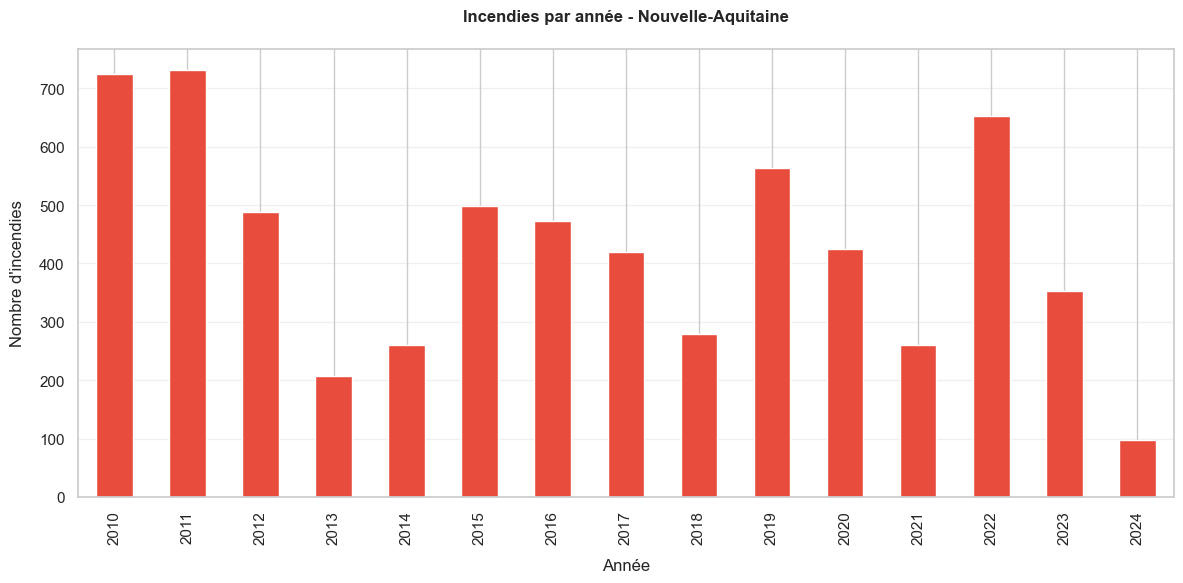


● Répartition par mois


,Nombre d'incendies
Janvier,22
Février,182
Mars,809
Avril,890
Mai,435
Juin,484
Juillet,1111
Août,1284
Septembre,927
Octobre,237


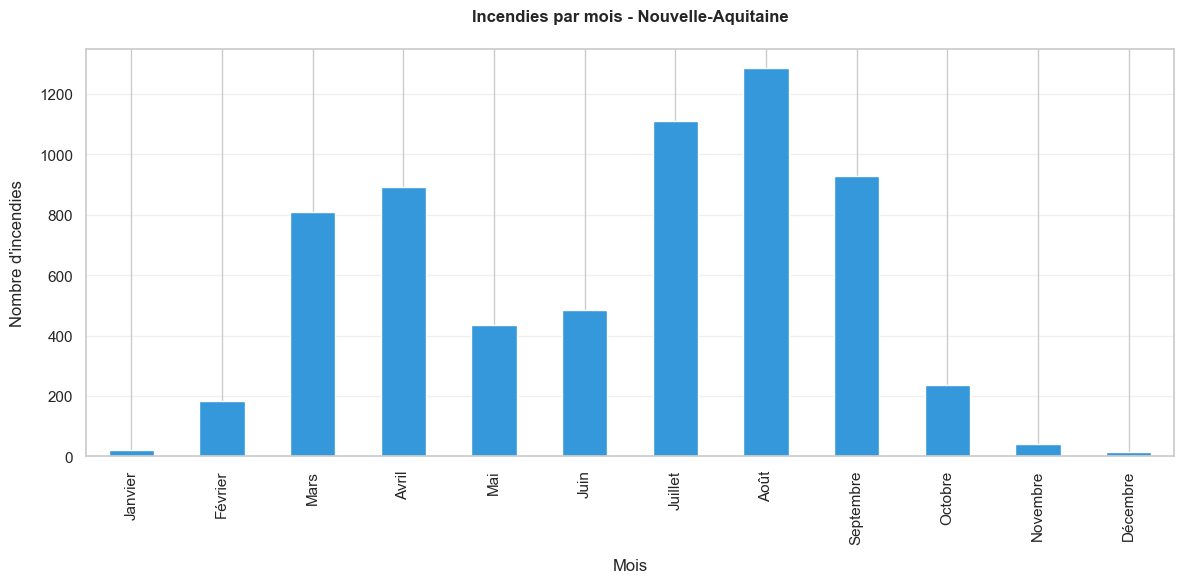


● Analyse géographique
Top 15 départements:


,Nombre d'incendies
département,
33,2546
40,1249
24,790
17,492
47,418
16,230
64,192
86,161
87,146


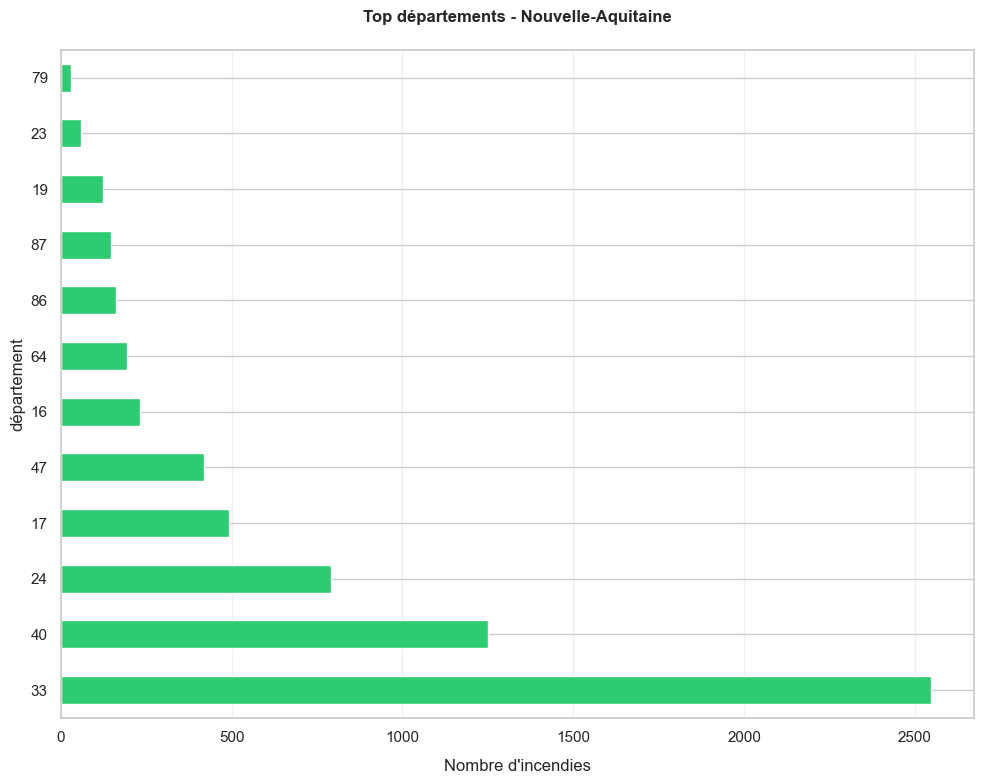


● Analyse des surfaces

Surface brûlée par année (ha):


,Surface brûlée (ha)
année,
2010,1242.7071
2011,1522.9444
2012,1111.4157
2013,451.6513
2014,374.8113
2015,1368.5507
2016,710.3339
2017,1993.4933
2018,261.5010


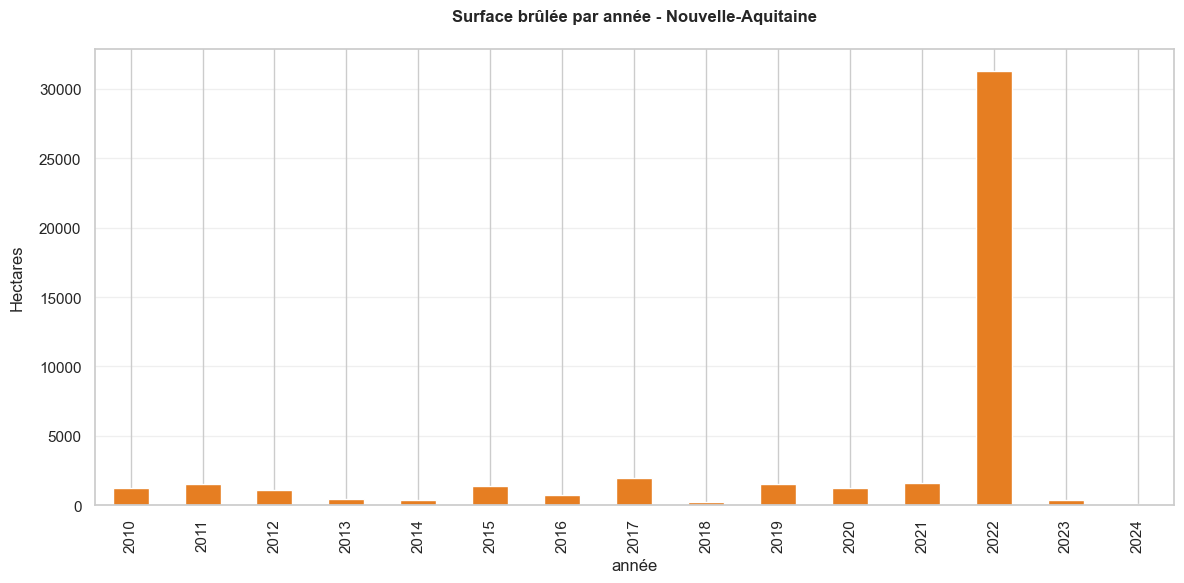


Surface brûlée par mois (ha):


,Surface brûlée (ha)
Juillet,22121.3746
Août,9567.3434
Septembre,5760.5504
Avril,3522.8652
Février,1453.1593
Mars,1297.7449
Juin,856.4631
Mai,327.7267
Octobre,291.0425
Janvier,16.6449


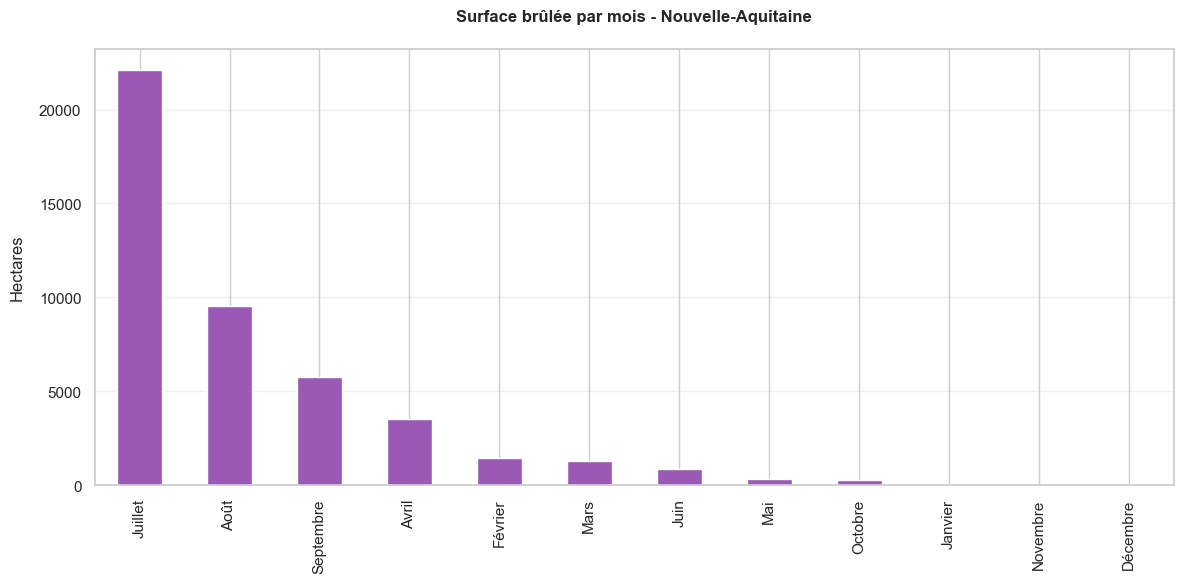

In [24]:
resultats_na = analyser_incendies(df_inc_na, "Nouvelle-Aquitaine")

Cette analyse porte sur les données des incendies survenus en Nouvelle-Aquitaine sur une période de près de 15 ans, allant de février 2010 à novembre 2024. L'objectif est de dégager les tendances clés, d'identifier les zones et les périodes à risque, et de quantifier l'impact de ces événements. L'étude se base sur un total de **6 435 incendies** recensés sur l'ensemble des **12 départements** de la région.

### **a. Statistiques Générales**
- **Nombre total d'incendies** : 6 435
- **Période couverte** : 2010-02-24 au 2024-11-30
- **Nombre de départements analysés** : 12

### **b. Analyse Temporelle**

#### Répartition par Année
L'activité des incendies montre une forte variabilité annuelle.

- **Années les plus actives (nombre de feux)** :
    - 2011 : 731 incendies
    - 2010 : 725 incendies
    - 2022 : 653 incendies

- **Année la plus dévastatrice (surface brûlée)** : 2022 se distingue de manière exceptionnelle avec **31 310 hectares brûlés**, un chiffre largement supérieur à toutes les autres années de la période.

#### Répartition par Mois
La saisonnalité des incendies est très marquée, avec un pic de risque durant les mois chauds.

- **Mois avec le plus grand nombre de départs de feu** :
    - Août : 1 284 feux
    - Juillet : 1 111 feux
    - Septembre : 927 feux

- **Mois avec les plus grandes surfaces brûlées** :
    - Juillet : 22 121 ha
    - Août : 9 567 ha
    - Septembre : 5 760 ha

Ces chiffres confirment que la période estivale concentre à la fois la fréquence et l'intensité des incendies.

### **c. Analyse Géographique**

#### Répartition par Département
Le risque d'incendie est très inégalement réparti sur le territoire de la Nouvelle-Aquitaine.

- **Top 3 des départements les plus touchés** :
    1. Gironde (33) : 2 546 incendies
    2. Landes (40) : 1 249 incendies
    3. Dordogne (24) : 790 incendies

La Gironde et les Landes représentent à eux seuls près de **60%** du nombre total d'incendies de la région, ce qui souligne la vulnérabilité du massif forestier des Landes de Gascogne.

### **d. Synthèse et Conclusion**
L'analyse des données sur 15 ans révèle plusieurs points saillants :
- **Un risque fortement saisonnier** : Le danger est maximal en été (juillet-août), où les conditions de sécheresse et de chaleur favorisent les départs de feu et leur propagation.
- **Une concentration géographique** : Les départements de la Gironde et des Landes sont les plus exposés, en raison de leur vaste couvert forestier.
- **L'impact des événements extrêmes** : L'année 2022 a été une année record en termes de surface brûlée, démontrant la capacité de destruction massive des mégafeux et la vulnérabilité de la région face à des conditions climatiques exceptionnelles.

---

### 6.2. Analyse Descriptive des Incendies de Forêt pour la rovence-Alpes-Côte d'Azur


=== ANALYSE INCENDIES - PROVENCE-ALPES-CÔTE D'AZUR ===

● Statistiques générales


,Valeur
Nombre total d'incendies,7530
Nombre de départements,6
Nombre de communes,811
Période couverte,2010-01-31 au 2024-12-29



● Répartition par année


,Nombre d'incendies
année,
2010,354
2011,434
2012,560
2013,253
2014,237
2015,408
2016,613
2017,733
2018,290


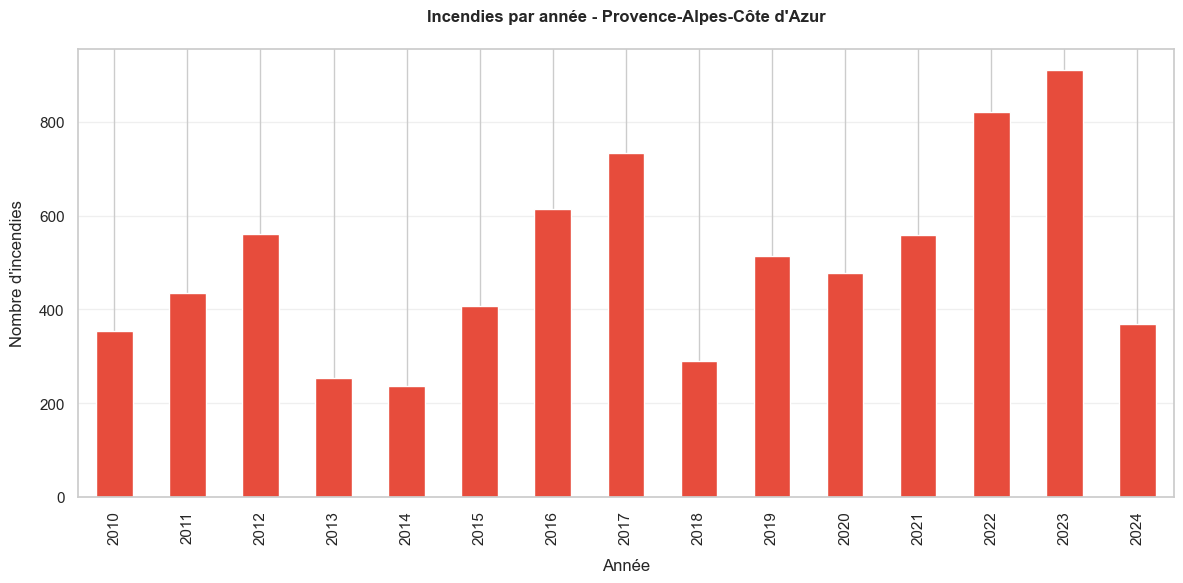


● Répartition par mois


,Nombre d'incendies
Janvier,250
Février,450
Mars,653
Avril,582
Mai,412
Juin,712
Juillet,1752
Août,1603
Septembre,611
Octobre,280


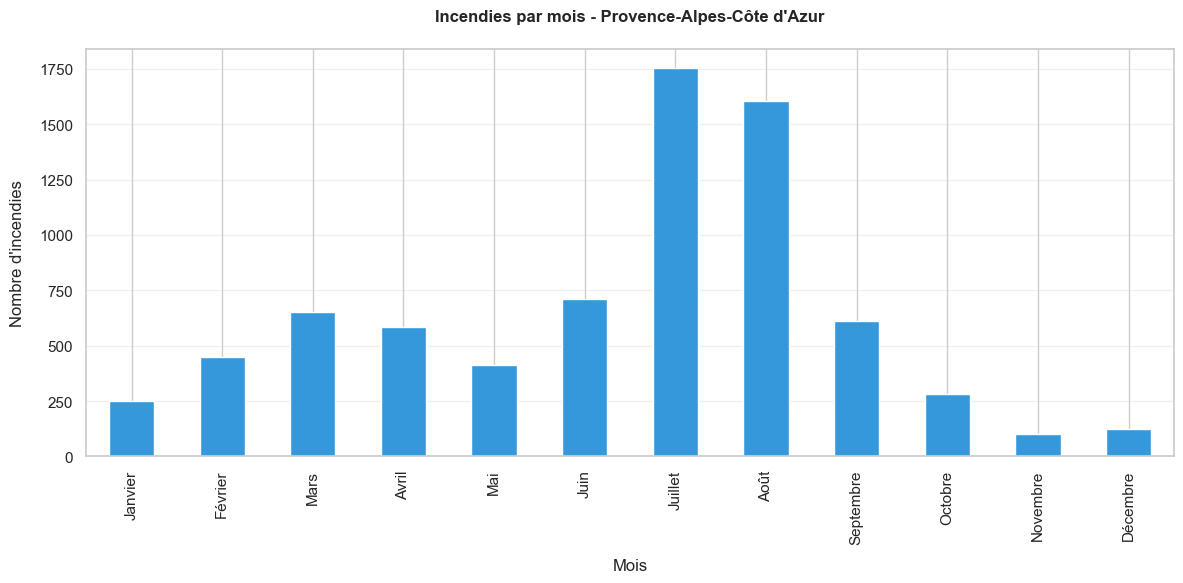


● Analyse géographique
Top 15 départements:


,Nombre d'incendies
département,
13,3259
83,1571
6,1188
4,781
84,495
5,236


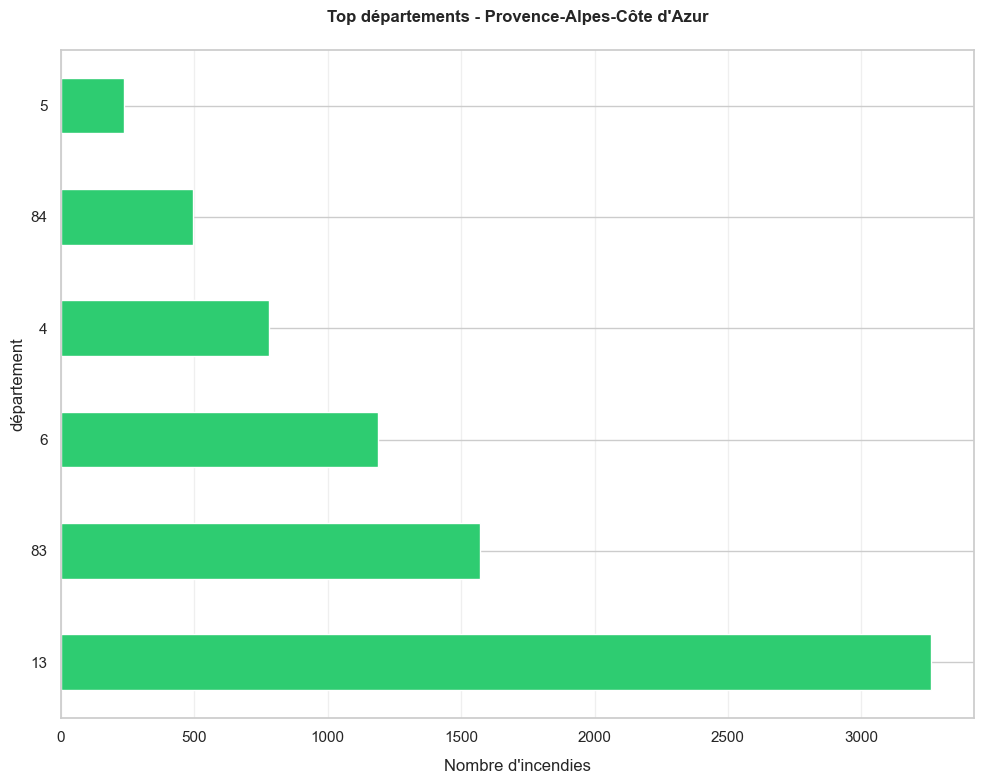


● Analyse des surfaces

Surface brûlée par année (ha):


,Surface brûlée (ha)
année,
2010,1343.3714
2011,697.2860
2012,1563.1919
2013,210.1017
2014,259.3945
2015,693.1510
2016,5948.1162
2017,8474.1813
2018,154.7847


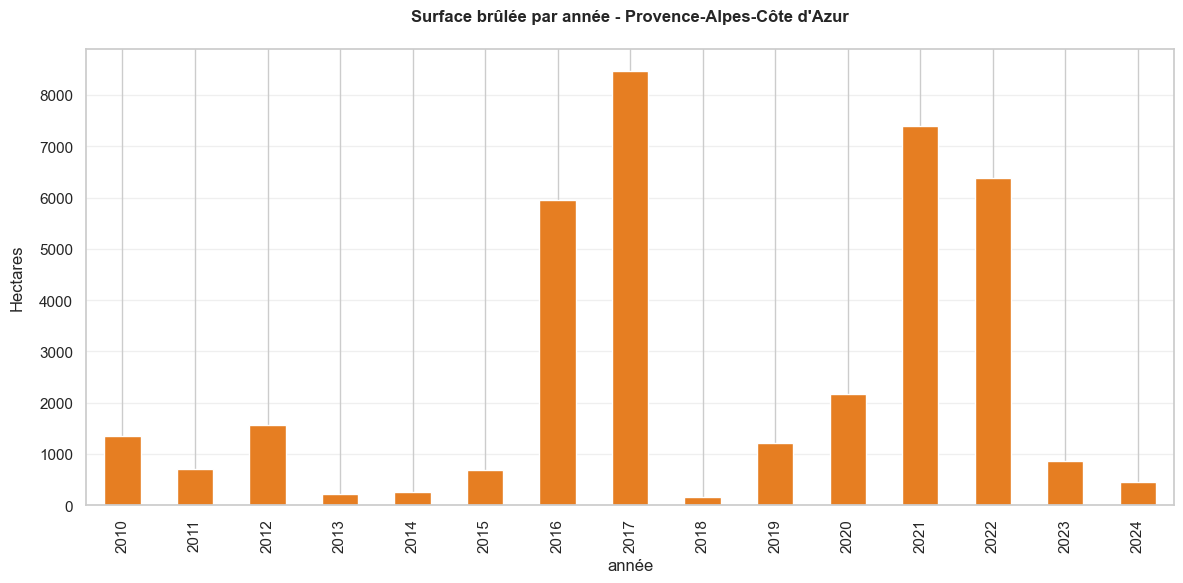


Surface brûlée par mois (ha):


,Surface brûlée (ha)
Août,15122.8745
Juillet,11994.9183
Juin,3304.2448
Mars,1868.2464
Février,1602.5710
Septembre,1299.6165
Octobre,812.9008
Avril,752.0958
Janvier,423.7181
Décembre,297.1229


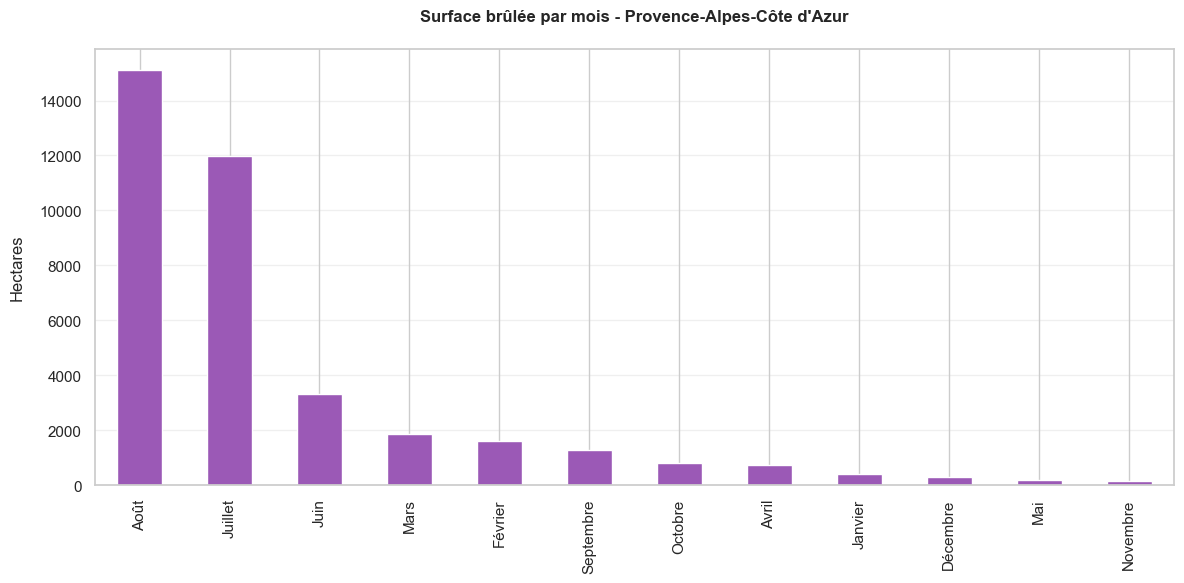

In [25]:
resultats_paca = analyser_incendies(df_inc_paca, "Provence-Alpes-Côte d'Azur")

Cette analyse se concentre sur les incendies survenus dans la région Provence-Alpes-Côte d'Azur (PACA) sur la période 2010-2024. Région au climat méditerranéen, PACA est historiquement l'une des zones les plus sensibles au risque d'incendie en France. L'étude vise à quantifier ce risque, à en dégager les principales tendances temporelles et à identifier les départements les plus touchés.

### **a. Analyse Temporelle**

#### Répartition par Année
Le nombre d'incendies en région PACA montre une tendance à la hausse sur la période récente, avec des pics de surface brûlée très marqués.

- **Années les plus actives (nombre de feux)** :
    - 2023 : près de 900 incendies
    - 2022 : plus de 800 incendies
    - 2017 : plus de 700 incendies

- **Années les plus dévastatrices (surface brûlée)** :
    - 2017 : environ 8 500 hectares
    - 2021 : environ 7 500 hectares
    - 2022 : environ 6 500 hectares
    - 2016 : environ 6 000 hectares

Contrairement à la Nouvelle-Aquitaine où 2022 était une anomalie, la région PACA a connu plusieurs années de forte intensité, notamment 2016, 2017, 2021 et 2022.

### Répartition par Mois
La saisonnalité est extrêmement marquée, avec un pic de risque concentré sur les mois d'été.

- **Mois avec le plus grand nombre de départs de feu** :
    - Juillet : environ 1 750 feux
    - Août : environ 1 600 feux

- **Mois avec les plus grandes surfaces brûlées** :
    - Août : près de 15 000 ha
    - Juillet : environ 12 000 ha
    - Juin : plus de 3 000 ha

L'été (juin, juillet, août) représente l'écrasante majorité des départs de feu et des surfaces détruites, bien plus encore que dans d'autres régions.

### **b. Analyse Géographique**

### Répartition par Département
Le risque est très concentré sur certains départements du littoral et de l'arrière-pays.

- **Top 3 des départements les plus touchés (nombre d'incendies)** :
    1. Bouches-du-Rhône (13) : plus de 3 000 incendies
    2. Var (83) : environ 1 500 incendies
    3. Alpes-Maritimes (06) : environ 1 100 incendies

Les Bouches-du-Rhône sont de loin le département le plus affecté, subissant plus du double des incendies du Var. Ces trois départements côtiers concentrent l'essentiel du risque régional.
 
### **c. Synthèse et Conclusion**
L'analyse des incendies en région PACA confirme son statut de "hotspot" national :
- **Un risque estival extrême** : Le danger est massivement concentré en juillet et août, qui cumulent un nombre très élevé de départs de feu et des surfaces brûlées considérables.
- **Une tendance à l'intensification** : Les années récentes (2016, 2017, 2021, 2022, 2023) montrent une activité et/ou une intensité particulièrement fortes, suggérant une augmentation du risque.
- **Une forte polarisation géographique** : Les Bouches-du-Rhône (13) et le Var (83) sont les épicentres du risque d'incendie dans la région.

La situation en PACA illustre un risque incendie structurel et intense, exacerbé durant les étés, et qui semble s'aggraver au fil des ans, rendant les politiques de gestion du territoire et de lutte d'autant plus critiques.

---

### 7. Analyse des Surfaces Brûlées

Cette section fournit une **analyse approfondie des surfaces parcourues par les incendies**, selon les spécifications du BDIFF, en prenant en compte :
- La présence ou l'absence de végétation.
- La distinction entre végétation présente mais non brûlée, et effectivement brûlée.
- La typologie des végétations impactées.

#### a. Objectifs :
- Calculer des **statistiques globales** sur les surfaces brûlées (moyenne, médiane, min, max, écart-type…).
- Étudier la **distribution logarithmique** des surfaces brûlées.
- Distinguer les **types de végétation affectés** par les incendies.
- Évaluer la **présence réelle ou absente de végétation** selon les zones.
- Analyser la **répartition des sinistres selon des classes de surface brûlée** :  
  `<1 ha`, `1-10 ha`, `10-100 ha`, `100-1000 ha`, `>1000 ha`.

#### b. Résultats produits :
- **Tableaux statistiques** :
  - Surface totale brûlée (en hectares).
  - Moyennes par type de végétation brûlée.
  - Pourcentages de présence et d'absence de végétation.
  - Répartition par classe de surface.

- **Graphiques générés** :
  - Histogramme de la distribution des surfaces (échelle logarithmique).
  - Barres des surfaces moyennes brûlées par type de végétation.
  - Barres empilées de la présence de végétation (brûlée, non brûlée, absente).
  - Répartition (%) des incendies par classe de surface.

> *Remarque : cette fonction s’adapte dynamiquement aux colonnes disponibles dans le DataFrame. Elle assure également la lisibilité des résultats via des visualisations claires, prêtes à être exportées ou intégrées à un rapport final.*

> **Remarque importante sur l’interprétation des colonnes de surfaces végétales**
>
> Lors de l’analyse des colonnes spécifiques comme `surface_forêt_(m2)`, `surface_maquis_garrigues_(m2)`, etc., il est essentiel de respecter la sémantique définie par la base BDIFF :
>
> - **Valeur vide (NaN)** : ne correspond **pas à une donnée manquante**, mais indique que le **type de végétation est absent** de la zone sinistrée.
> - **Valeur nulle (0)** : signifie que le type de végétation était **présent mais n’a pas été impacté** par le feu.
>
> Ainsi, **aucune imputation automatique n’a été réalisée** sur ces colonnes afin de préserver l’information structurelle.  
> Les valeurs NaN ont volontairement été conservées pour distinguer l’**absence réelle de végétation** de la **non-brûlure d’une végétation présente**.
>
> La colonne `surface_parcourue_(m2)` reste la **référence principale** pour évaluer l’intensité des incendies.  
> Les colonnes de surface détaillées, quant à elles, permettent une **lecture fine de l’impact selon le type de couvert végétal**.



In [26]:
def analyse_surfaces_brûlées(df, region_name):
    """
    Analyse complète des surfaces brûlées selon les spécifications BDIFF
    - Conserve la sémantique des valeurs vides (végétation absente)
    - Traite différemment les valeurs nulles (végétation présente mais non brûlée)
    - Utilise surface_parcourue_(m2) comme référence principale
    
    Returns:
        dict: Résultats contenant DataFrames et figures
    """
    results = {
        'region': region_name,
        'dataframes': {},
        'figures': {},
        'graphiques_sauvegardes': {}
    }
    
    # Vérification des colonnes nécessaires
    if 'surface_parcourue_(m2)' not in df.columns:
        print(f"Colonne 'surface_parcourue_(m2)' manquante pour {region_name}")
        return results
    
    # Copie du dataframe pour éviter les modifications accidentelles
    df = df.copy()
    
    # Conversion en hectares
    df['surface_parcourue_ha'] = df['surface_parcourue_(m2)'] / 10000
    
    # 1. Statistiques de base (surface totale)
    stats = {
        'Total surface brûlée (ha)': df['surface_parcourue_ha'].sum(),
        'Moyenne (ha)': df['surface_parcourue_ha'].mean(),
        'Médiane (ha)': df['surface_parcourue_ha'].median(),
        'Minimum (ha)': df['surface_parcourue_ha'].min(),
        'Maximum (ha)': df['surface_parcourue_ha'].max(),
        'Écart-type (ha)': df['surface_parcourue_ha'].std(),
        'Nombre incendies': len(df)
    }
    results['dataframes']['statistiques_globales'] = pd.DataFrame.from_dict(stats, orient='index', columns=['Valeur'])
    
    print(f"\n\033[1m=== ANALYSE SURFACES BRÛLÉES - {region_name.upper()} ===\033[0m")
    print("\n● STATISTIQUES GLOBALES")
    display(results['dataframes']['statistiques_globales'])
    
    # 2. Distribution des surfaces (échelle logarithmique)
    fig1, ax1 = plt.subplots(figsize=(12, 6))
    ax1.hist(df['surface_parcourue_ha'], 
             bins=np.logspace(0, 5, 50), 
             edgecolor='black', 
             color='#3498db')
    ax1.set_xscale('log')
    ax1.set_title(f'Distribution des surfaces brûlées ({region_name})', pad=15)
    ax1.set_xlabel('Surface (hectares) - échelle logarithmique')
    ax1.set_ylabel('Nombre d\'incendies')
    ax1.grid(True, which="both", ls="--", alpha=0.5)
    
    results['figures']['distribution_surfaces'] = fig1
    results['graphiques_sauvegardes']['distribution_surfaces'] = sauvegarder_graphique(fig1, f"distribution_surfaces_{region_name}")
    plt.show()
    
    # 3. Analyse par type de végétation
    colonnes_vegetation = [
        'surface_forêt_(m2)', 
        'surface_maquis_garrigues_(m2)',
        'autres_surfaces_naturelles_hors_forêt_(m2)',
        'surfaces_agricoles_(m2)',
        'autres_surfaces_(m2)',
        'surface_autres_terres_boisées_(m2)',
        'surfaces_non_boisées_naturelles_(m2)',
        'surfaces_non_boisées_artificialisées_(m2)'
    ]
    
    # a. Surfaces brûlées moyennes par type
    surfaces_moyennes = {}
    presence_vegetation = {}
    
    for col in colonnes_vegetation:
        if col in df.columns:
            # Filtre : seulement les incendies où la végétation était présente (non vide) ET brûlée (>0)
            mask = (df[col].notna()) & (df[col] > 0)
            surfaces_moyennes[col.replace('_(m2)', '')] = df.loc[mask, col].mean() / 10000
            
            # Statistiques de présence/absence
            total = len(df)
            absent = df[col].isna().sum()
            presente_non_brulée = (df[col] == 0).sum()
            presente_brulée = total - absent - presente_non_brulée
            
            presence_vegetation[col.replace('_(m2)', '')] = {
                'Absente (%)': (absent / total) * 100,
                'Présente non brûlée (%)': (presente_non_brulée / total) * 100,
                'Présente et brûlée (%)': (presente_brulée / total) * 100
            }
    
    if surfaces_moyennes:
        results['dataframes']['surfaces_brûlées_moyennes'] = pd.DataFrame.from_dict(surfaces_moyennes, orient='index', columns=['Surface moyenne (ha)'])
        results['dataframes']['presence_vegetation'] = pd.DataFrame(presence_vegetation).T
        
        print("\n● SURFACES BRÛLÉES MOYENNES PAR TYPE DE VÉGÉTATION (ha)")
        display(results['dataframes']['surfaces_brûlées_moyennes'].sort_values('Surface moyenne (ha)', ascending=False))
        
        print("\n● PRÉSENCE DES TYPES DE VÉGÉTATION DANS LES INCENDIES")
        display(results['dataframes']['presence_vegetation'])
        
        # b. Visualisation des surfaces brûlées par type
        df_surfaces = results['dataframes']['surfaces_brûlées_moyennes'].sort_values('Surface moyenne (ha)', ascending=False)
        
        fig2, ax2 = plt.subplots(figsize=(12, 6))
        df_surfaces.plot(kind='bar', ax=ax2, color='#2ecc71', edgecolor='black')
        ax2.set_title(f'Surfaces brûlées moyennes par type de végétation\n({region_name})', pad=15)
        ax2.set_ylabel('Surface moyenne brûlée (ha)')
        ax2.tick_params(axis='x', rotation=45)
        ax2.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        
        results['figures']['surfaces_par_vegetation'] = fig2
        results['graphiques_sauvegardes']['surfaces_par_vegetation'] = sauvegarder_graphique(fig2, f"surfaces_par_vegetation_{region_name}")
        plt.show()
        
        # c. Visualisation de la présence de végétation
        df_presence = results['dataframes']['presence_vegetation'].sort_values('Présente et brûlée (%)', ascending=False)
        
        fig3, ax3 = plt.subplots(figsize=(14, 7))
        df_presence.plot(kind='bar', stacked=True, ax=ax3,
                        color=['#95a5a6', '#f1c40f', '#e74c3c'])
        ax3.set_title(f'Présence des types de végétation dans les incendies\n({region_name})', pad=15)
        ax3.set_ylabel('Répartition (%)')
        ax3.tick_params(axis='x', rotation=45)
        ax3.legend(title='Statut', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        
        results['figures']['presence_vegetation'] = fig3
        results['graphiques_sauvegardes']['presence_vegetation'] = sauvegarder_graphique(fig3, f"presence_vegetation_{region_name}")
        plt.show()
    
    # 4. Répartition par classe de surface
    bins = [0, 1, 10, 100, 1000, float('inf')]
    labels = ['<1 ha', '1-10 ha', '10-100 ha', '100-1000 ha', '>1000 ha']
    
    df['classe_surface'] = pd.cut(df['surface_parcourue_ha'], 
                                 bins=bins, 
                                 labels=labels, 
                                 right=False)
    
    distribution = df['classe_surface'].value_counts(normalize=True).sort_index() * 100
    results['dataframes']['repartition_classe'] = distribution.to_frame('Pourcentage (%)')
    
    print("\n● RÉPARTITION PAR CLASSE DE SURFACE")
    display(results['dataframes']['repartition_classe'])
    
    # Visualisation
    fig4, ax4 = plt.subplots(figsize=(10, 6))
    distribution.plot(kind='bar', ax=ax4, color='#e74c3c', edgecolor='black')
    
    for i, val in enumerate(distribution):
        ax4.text(i, val + 1, f'{val:.1f}%', ha='center', va='bottom', fontsize=10)
    
    ax4.set_title(f'Répartition des incendies par classe de surface\n({region_name})', pad=15)
    ax4.set_xlabel('Classe de surface')
    ax4.set_ylabel('Pourcentage des incendies (%)')
    ax4.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    
    results['figures']['repartition_classe'] = fig4
    results['graphiques_sauvegardes']['repartition_classe'] = sauvegarder_graphique(fig4, f"repartition_classe_{region_name}")
    plt.show()
    
    return results

### 7.1. Analyse des Surfaces Brûlées de la Nouvelle-Aquitaine


=== ANALYSE SURFACES BRÛLÉES - NOUVELLE-AQUITAINE ===

● STATISTIQUES GLOBALES


,Valeur
Total surface brûlée (ha),45221.872800
Moyenne (ha),7.027486
Médiane (ha),0.200000
Minimum (ha),0.000100
Maximum (ha),12552.000000
Écart-type (ha),196.881109
Nombre incendies,6435.000000


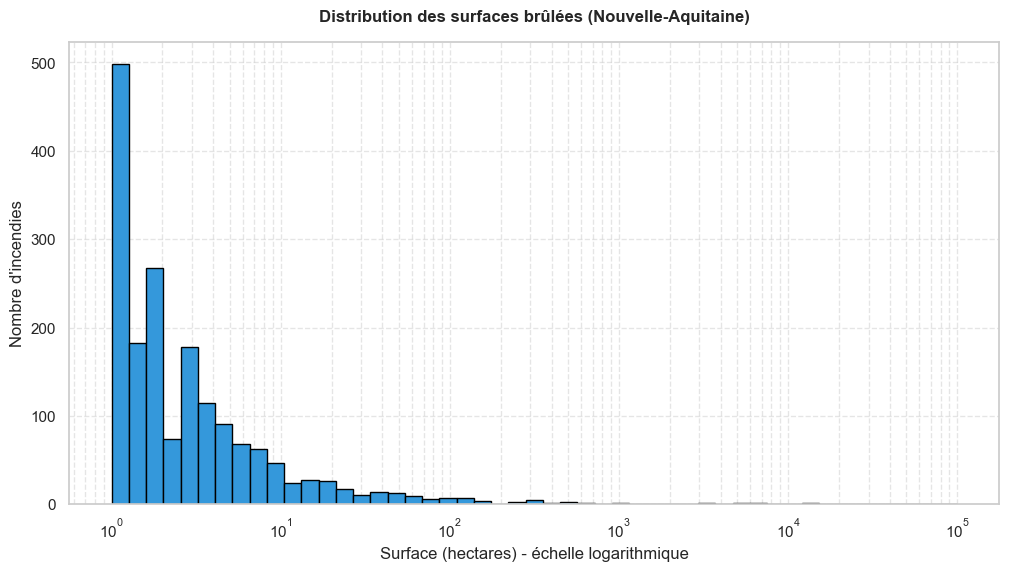


● SURFACES BRÛLÉES MOYENNES PAR TYPE DE VÉGÉTATION (ha)


,Surface moyenne (ha)
surfaces_agricoles,10.482365
surface_forêt,6.858614
surface_autres_terres_boisées,5.674768
autres_surfaces_naturelles_hors_forêt,5.474503
surfaces_non_boisées_naturelles,4.847374
surfaces_non_boisées_artificialisées,3.799571
autres_surfaces,0.350314
surface_maquis_garrigues,NaN



● PRÉSENCE DES TYPES DE VÉGÉTATION DANS LES INCENDIES


,Absente (%),Présente non brûlée (%),Présente et brûlée (%)
surface_forêt,0.279720,5.159285,94.560995
surface_maquis_garrigues,100.000000,0.000000,0.000000
autres_surfaces_naturelles_hors_forêt,1.476301,91.686092,6.837607
surfaces_agricoles,91.157731,8.438228,0.404040
autres_surfaces,91.328671,8.562549,0.108780
surface_autres_terres_boisées,10.225330,84.180264,5.594406
surfaces_non_boisées_naturelles,84.475524,14.933955,0.590521
surfaces_non_boisées_artificialisées,84.475524,14.980575,0.543901


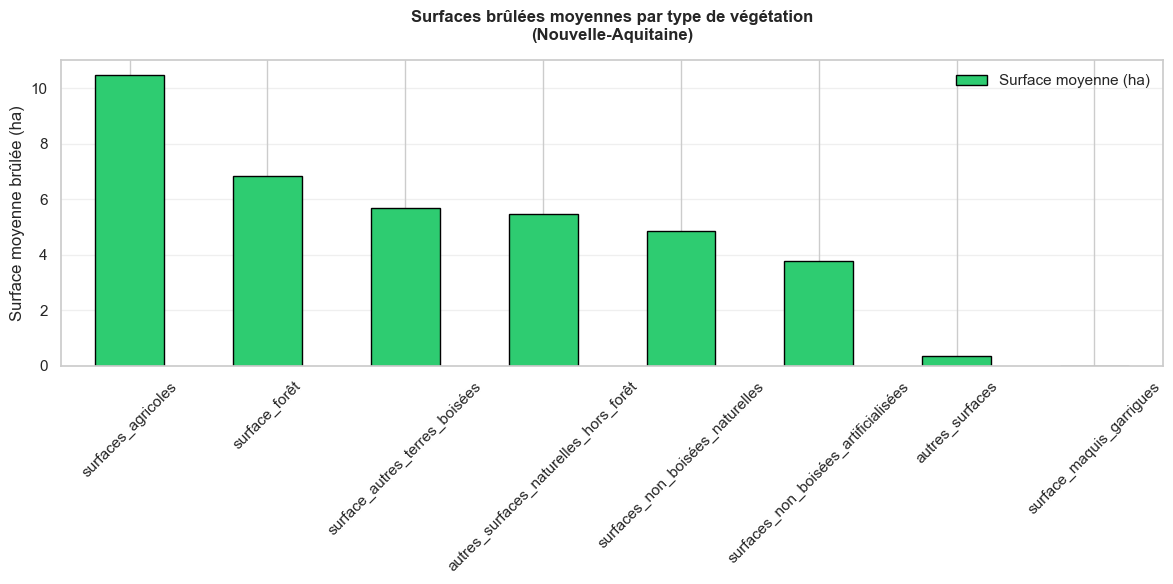

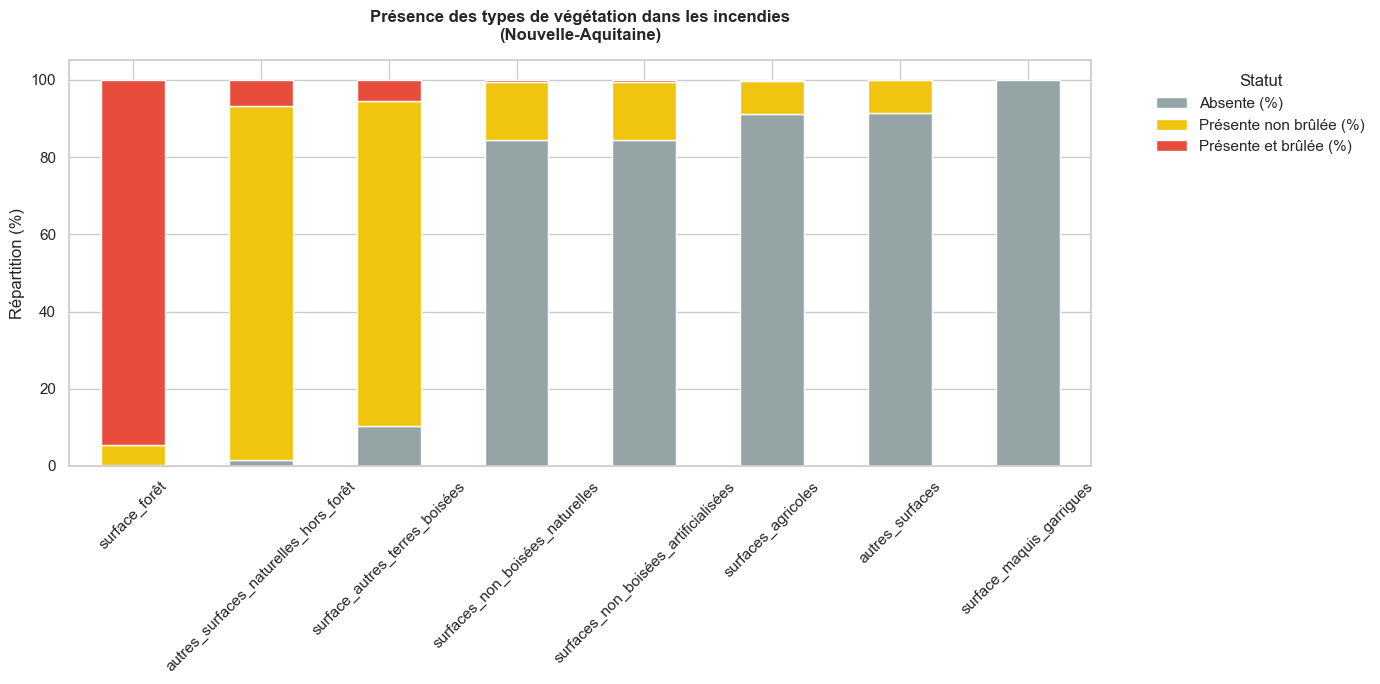


● RÉPARTITION PAR CLASSE DE SURFACE


,Pourcentage (%)
classe_surface,
<1 ha,72.571873
1-10 ha,24.149184
10-100 ha,2.750583
100-1000 ha,0.450660
>1000 ha,0.077700


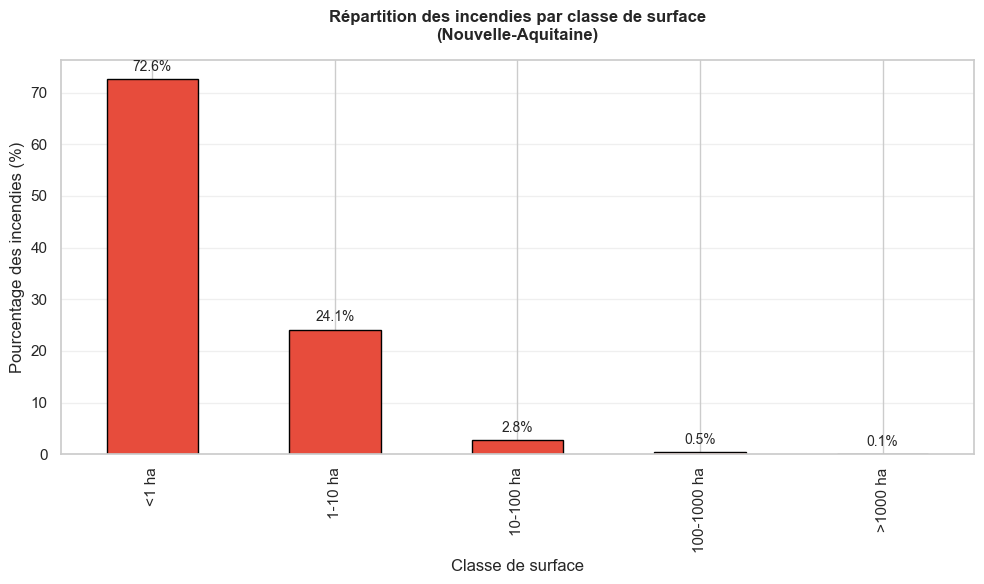

In [27]:
surf_na = analyse_surfaces_brûlées(df_inc_na, "Nouvelle-Aquitaine")

Cette analyse se penche sur la nature des surfaces touchées par les incendies en Nouvelle-Aquitaine. Au-delà du simple décompte des feux, il est essentiel de comprendre la taille des incendies et les types de végétation qu'ils parcourent. Cette étude se base sur les données de 6 435 incendies et un total de 45 221 hectares brûlés.

## 2. Distribution des Surfaces Brûlées
L'analyse statistique révèle une réalité clé : la grande majorité des incendies sont de petite taille, mais quelques événements extrêmes sont responsables de la majeure partie des dégâts.

- **Total de la surface brûlée** : 45 221 ha
- **Surface maximale pour un seul incendie** : 12 552 ha
- **Moyenne par incendie** : 7,0 ha
- **Médiane par incendie** : 0,2 ha (ce qui signifie que 50% des incendies ont brûlé moins de 0,2 hectare)

La différence énorme entre la moyenne et la médiane confirme que la plupart des feux sont rapidement maîtrisés, tandis qu'un petit nombre de "mégafeux" fait grimper la moyenne de manière disproportionnée.

### Répartition par Classe de Surface
Cette asymétrie est confirmée par la répartition des incendies par taille :
- Près de 73% des incendies parcourent moins d'un hectare.
- 96,7% des incendies font moins de 10 hectares.
- Seulement 0,5% des feux dépassent les 100 hectares, mais ils sont les plus destructeurs.

## 3. Analyse par Type de Végétation

### 3.1. Quelle végétation brûle le plus ?
L'analyse de la présence des types de végétation dans les zones d'incendie montre un résultat sans équivoque :
- La forêt est le type de végétation le plus touché, présente et brûlant dans 94,6% des cas d'incendie.
- Les autres terres boisées et les autres surfaces naturelles hors forêt sont également souvent présentes, mais elles brûlent beaucoup plus rarement (respectivement dans 5,6% et 6,8% des cas).
- Les surfaces agricoles et les surfaces artificialisées sont très rarement touchées.

À noter : les maquis et garrigues sont totalement absents des données pour cette région.

**Graphique 2** : Présence des types de végétation dans les incendies.

### 3.2. Quelle végétation conduit aux plus grands incendies ?
Lorsqu'un incendie touche un type de végétation, la surface moyenne brûlée varie :
- **Surfaces agricoles** : 10,5 ha en moyenne. Bien que rarement touchées, elles peuvent conduire à des feux étendus (feux de chaume, etc.).
- **Forêt** : 6,9 ha en moyenne.
- **Autres terres boisées** : 5,7 ha en moyenne.

Cela suggère que si les feux en forêt sont les plus fréquents, les feux en milieu agricole, bien que rares, peuvent être significatifs en taille.

## 4. Synthèse et Conclusion
- **La tyrannie des grands feux** : La Nouvelle-Aquitaine est caractérisée par une multitude de petits incendies (plus de 70% < 1 ha) et une poignée d'événements catastrophiques qui causent l'essentiel des dommages.
- **La forêt en première ligne** : Le risque d'incendie dans la région est avant tout un risque de feu de forêt. C'est le milieu qui brûle le plus souvent et de manière significative.
- **Des risques secondaires** : Bien que moins fréquents, les feux en milieu agricole peuvent également parcourir des surfaces importantes et ne doivent pas être négligés.

En conclusion, la gestion du risque incendie en Nouvelle-Aquitaine doit prioritairement se concentrer sur la prévention et la lutte contre les feux de forêt, tout en gardant à l'esprit que la dynamique des feux est dominée par des événements rares mais de très grande ampleur.

### 7. Analyse des Surfaces Brûlées de la Provence-Alpes-Côte d'Azur


=== ANALYSE SURFACES BRÛLÉES - PROVENCE-ALPES-CÔTE D'AZUR ===

● STATISTIQUES GLOBALES


,Valeur
Total surface brûlée (ha),37838.983500
Moyenne (ha),5.025097
Médiane (ha),0.040000
Minimum (ha),0.000100
Maximum (ha),6832.000000
Écart-type (ha),99.510330
Nombre incendies,7530.000000


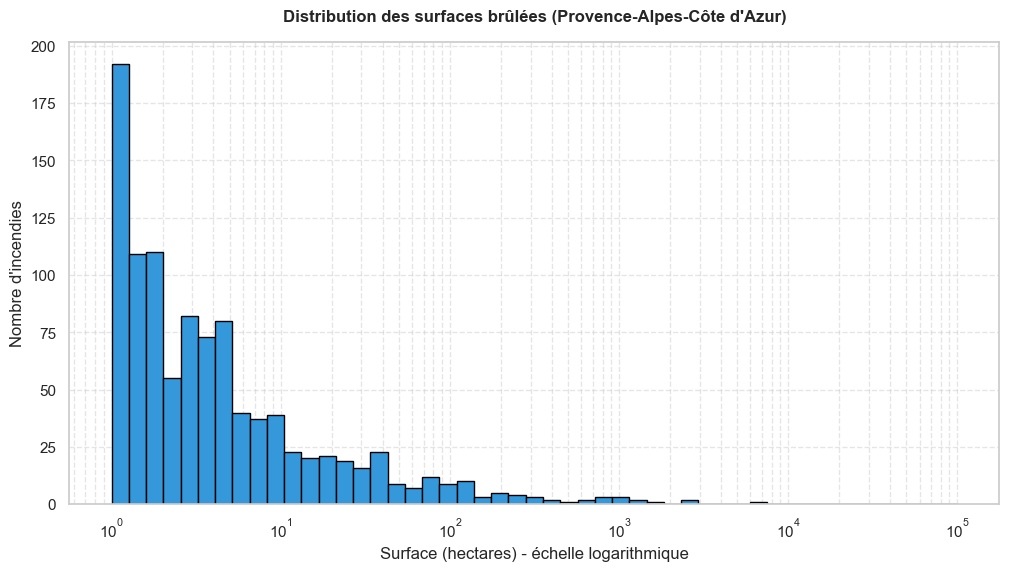


● SURFACES BRÛLÉES MOYENNES PAR TYPE DE VÉGÉTATION (ha)


,Surface moyenne (ha)
autres_surfaces_naturelles_hors_forêt,5.955797
surface_forêt,4.796984
surface_maquis_garrigues,3.370644
autres_surfaces,0.760030
surfaces_agricoles,0.519667
surface_autres_terres_boisées,NaN
surfaces_non_boisées_naturelles,NaN
surfaces_non_boisées_artificialisées,NaN



● PRÉSENCE DES TYPES DE VÉGÉTATION DANS LES INCENDIES


,Absente (%),Présente non brûlée (%),Présente et brûlée (%)
surface_forêt,17.729084,11.434263,70.836653
surface_maquis_garrigues,53.346614,17.994688,28.658699
autres_surfaces_naturelles_hors_forêt,83.798141,15.816733,0.385126
surfaces_agricoles,83.798141,16.082337,0.119522
autres_surfaces,83.798141,15.896414,0.305445
surface_autres_terres_boisées,100.000000,0.000000,0.000000
surfaces_non_boisées_naturelles,100.000000,0.000000,0.000000
surfaces_non_boisées_artificialisées,100.000000,0.000000,0.000000


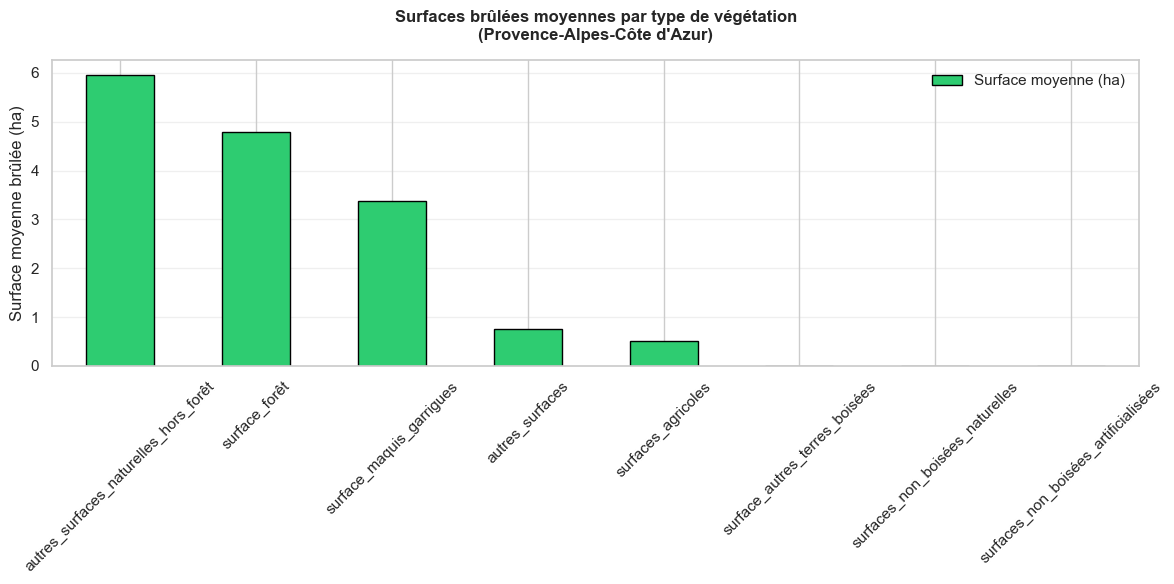

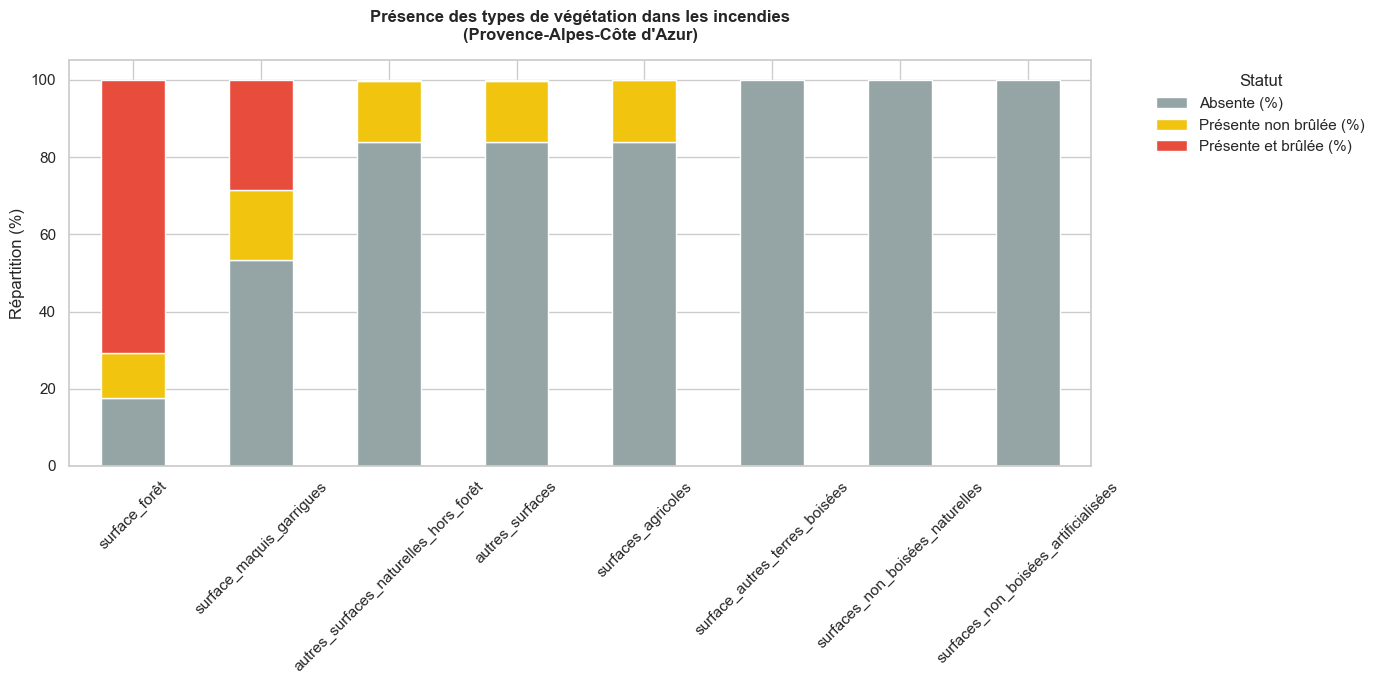


● RÉPARTITION PAR CLASSE DE SURFACE


,Pourcentage (%)
classe_surface,
<1 ha,86.480744
1-10 ha,10.717131
10-100 ha,2.191235
100-1000 ha,0.517928
>1000 ha,0.092961


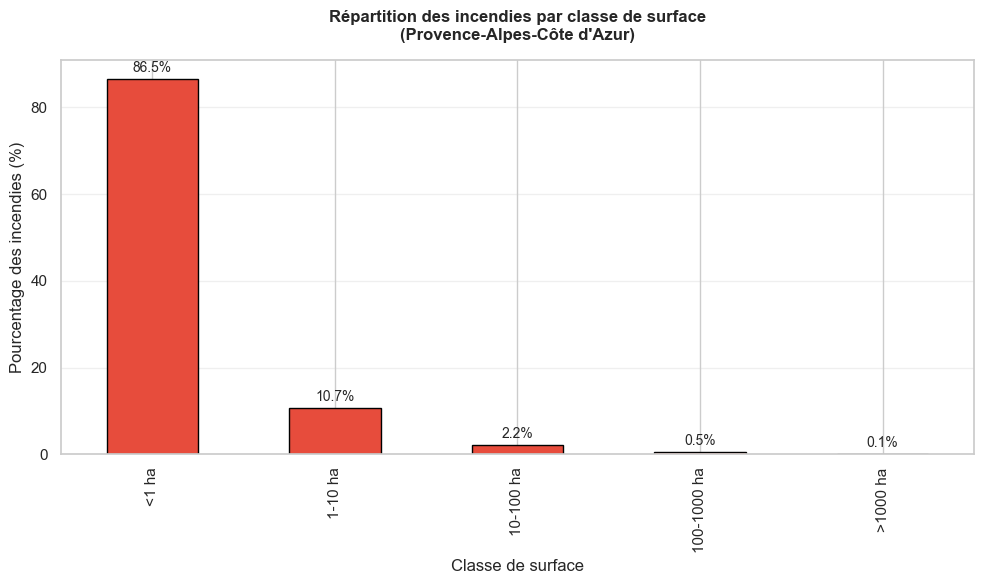

In [28]:
surf_paca = analyse_surfaces_brûlées(df_inc_paca, "Provence-Alpes-Côte d'Azur")

Cette section explore en détail les caractéristiques des surfaces touchées par les 7 530 incendies en région Provence-Alpes-Côte d'Azur (PACA). L'analyse vise à comprendre la distribution des tailles d'incendies et à identifier les types de végétation les plus vulnérables dans cette région au climat méditerranéen particulièrement exposé au risque de feu. Au total, 37 839 hectares ont brûlé sur la période étudiée.

### **a. Distribution des Surfaces Brûlées**
Comme en Nouvelle-Aquitaine, l'analyse statistique pour PACA met en évidence une forte disparité entre la multitude de petits feux et l'impact de quelques grands incendies.

- **Total de la surface brûlée** : 37 839 ha
- **Surface maximale pour un seul incendie** : 6 832 ha
- **Moyenne par incendie** : 5,0 ha
- **Médiane par incendie** : 0,04 ha (encore plus faible qu'en Nouvelle-Aquitaine, indiquant que 50% des feux ont brûlé moins de 400 m²).

L'écart extrême entre la moyenne et la médiane est la signature d'une région où la très grande majorité des départs de feu est stoppée très rapidement, mais où le potentiel de propagation des feux restants est immense.

### Répartition par Classe de Surface
La concentration des feux de petite taille est encore plus marquée en PACA :
- 86,5% des incendies parcourent moins d'un hectare.
- 97,2% des incendies font moins de 10 hectares.
- Seulement 0,6% des feux dépassent les 100 hectares, mais ils sont responsables de la majorité des surfaces détruites.

### **b. Analyse par Type de Végétation**

### Quelle végétation brûle le plus ?
La végétation méditerranéenne est au cœur du risque incendie en PACA.
- La forêt est le milieu qui brûle le plus souvent, étant présente et touchée dans 70,8% des incendies.
- Les maquis et garrigues jouent un rôle majeur, présents et brûlant dans 28,7% des cas, ce qui en fait le deuxième type de végétation le plus combustible.
- Les autres types de végétation (agricole, autres surfaces naturelles) sont très rarement la cible principale des flammes.

À noter : plusieurs catégories de végétation sont absentes des données pour cette région (terres boisées, surfaces non boisées naturelles/artificialisées).

### Quelle végétation conduit aux plus grands incendies ?
La surface moyenne brûlée varie selon le type de végétation initial :
- Autres surfaces naturelles hors forêt : 6,0 ha en moyenne.
- Forêt : 4,8 ha en moyenne.
- Maquis et garrigues : 3,4 ha en moyenne.

Bien que les forêts et garrigues brûlent le plus souvent, ce sont les "autres surfaces naturelles" qui, lorsqu'elles sont touchées, connaissent en moyenne les incendies les plus étendus.

### **c. Synthèse et Conclusion**
- **Une efficacité à double tranchant** : La région PACA démontre une très grande efficacité pour contenir la majorité des feux à un stade précoce (86,5% < 1 ha). Cependant, cette performance masque une vulnérabilité extrême aux quelques feux qui échappent à ce contrôle initial et deviennent des événements majeurs.
- **Le couple Forêt-Garrigue au cœur du risque** : Contrairement à la Nouvelle-Aquitaine, le risque en PACA n'est pas seulement forestier. Il est intrinsèquement lié à l'écosystème méditerranéen où forêts, maquis et garrigues s'entremêlent et constituent un combustible très réactif.
- **Un risque concentré** : La quasi-totalité des dégâts est causée par une infime fraction des incendies (moins de 1%), ce qui rend la stratégie de "lutte contre les éclosions" absolument vitale.

En conclusion, la gestion du risque en PACA repose sur une course contre la montre permanente pour stopper les départs de feu avant qu'ils n'atteignent une taille critique dans les combustibles très inflammables que sont les forêts et garrigues méditerranéennes.

---

### 8. Cartographie Interactive des Incendies

La fonction `create_fire_map` permet de générer des **cartes interactives des incendies** survenus dans une ou plusieurs régions françaises. Elle s’appuie sur la bibliothèque `folium` pour représenter à la fois la **densité des feux** (via une heatmap) et leur **répartition géographique détaillée**, avec des **couches dynamiques** par type, importance ou département.

### a. Objectifs de la Fonction

- Visualiser la **localisation précise** de chaque incendie à partir de ses coordonnées GPS.
- Offrir une lecture **multicritère et interactive** :
  - **Tous les incendies**
  - **Feux importants (>10 ha)**
  - **Par département**
- Générer une **heatmap pondérée** par la surface parcourue (en hectares).
- Fournir des **pop-ups informatifs** sur chaque événement (date, commune, surface, type de végétation...).

### b. Fonctionnalités Clés

- **Heatmap dynamique** colorée selon l’intensité des surfaces brûlées.
- **Cercle rouge/orange** pour les incendies majeurs (taille proportionnelle à la gravité).
- **Couches départementales** : filtrage possible par zone administrative.
- **Pop-up détaillé** : pour chaque incendie, affichage des principales informations (lieu, date, nature, surface...).
- **Contrôleur de couches** : pour afficher/masquer les types de couches (feux >10 ha, tous les feux, départements...).
- Possibilité de basculer vers une **vue satellite** ou une carte terrain.

### c. Export et Paramètres

- Le paramètre `combined` permet de :
  - `True` : générer une **carte combinée** pour toutes les régions fournies.
  - `False` : générer une **carte distincte** pour chaque région.
- Chaque carte est exportée au format **HTML interactif** (`.html`) pour visualisation hors notebook.
- Un fichier distinct est sauvegardé pour chaque région lorsque `combined=False`.

### d. Intérêt de cette Analyse Cartographique

Cette carte interactive permet :
- Une **exploration visuelle immédiate** des zones les plus touchées.
- Une **comparaison géographique** entre régions ou départements.
- Une **mise en évidence des feux extrêmes** et des zones à risque.
- Un support visuel fort pour la **sensibilisation**, la **prévention** ou l’**aide à la décision**.


In [29]:
def create_fire_map(df_list, region_names=None, combined=True, output_path='carte_incendies.html'):
    if region_names is None:
        region_names = [f"Région {i+1}" for i in range(len(df_list))]
    
    if len(df_list) != len(region_names):
        raise ValueError("Le nombre de DataFrames doit correspondre au nombre de noms de région")
    
    dfs = []
    for df, region in zip(df_list, region_names):
        df = df.copy()
        df['region'] = region
        df['surface_parcourue_ha'] = df['surface_parcourue_(m2)'] / 10000
        df['date_de_première_alerte'] = pd.to_datetime(df['date_de_première_alerte'], errors='coerce')
        dfs.append(df)
    
    if combined:
        df = pd.concat(dfs, ignore_index=True)
        dfs = [df]

    for i, df in enumerate(dfs):
        m = folium.Map(location=[44.5, 2.5], zoom_start=6, tiles='cartodbpositron')

        # Titre dynamique avec période de données - Style moderne
        title = "Carte des incendies - " + ("France" if combined else region_names[i])
        date_min = df['date_de_première_alerte'].min()
        date_max = df['date_de_première_alerte'].max()
        if pd.notnull(date_min) and pd.notnull(date_max):
            periode = f"Données de {date_min.strftime('%Y-%m-%d')} à {date_max.strftime('%Y-%m-%d')}"
        else:
            periode = "Période de données inconnue"

        title_html = f'''
        <div style="
            position: fixed;
            top: 10px;
            left: 50%;
            transform: translateX(-50%);
            z-index: 9999;
            background: rgba(255, 255, 255, 0.9);
            padding: 10px 20px;
            border-radius: 5px;
            box-shadow: 0 2px 6px rgba(0,0,0,0.3);
            font-family: 'Arial', sans-serif;
            text-align: center;
            border-left: 5px solid #ff5722;
        ">
            <h3 style="margin: 0; color: #333; font-size: 18px; font-weight: 700;">{title}</h3>
            <p style="margin: 5px 0 0; color: #666; font-size: 14px;">{periode}</p>
        </div>
        '''
        m.get_root().html.add_child(folium.Element(title_html))

        # Heatmap pondérée avec paramètres ajustés pour meilleure visibilité
        heat_data = df[['latitude', 'longitude', 'surface_parcourue_ha']].dropna().values.tolist()
        HeatMap(heat_data, 
                name='Heatmap (pondérée)', 
                min_opacity=0.3, 
                radius=25, 
                blur=20, 
                max_zoom=12,
                gradient={0.4: 'blue', 0.6: 'lime', 0.8: 'yellow', 1.0: 'red'}).add_to(m)

        # Feux importants >10ha - Points plus visibles
        feux_importants = df[df['surface_parcourue_ha'] > 10].copy()
        feux_importants['size'] = feux_importants['surface_parcourue_ha'].apply(lambda x: min(25, max(8, x/5)))  # Tailles augmentées
        cluster_grands = MarkerCluster(name="Feux > 10 ha").add_to(m)

        for _, row in feux_importants.iterrows():
            popup = create_popup(row)
            color = 'red' if row['surface_parcourue_ha'] > 50 else 'orange'
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=row['size'],
                color=color,
                fill=True,
                popup=popup,
                fill_opacity=0.8,  # Opacité augmentée
                weight=2,  # Contour plus épais
            ).add_to(cluster_grands)

        # Tous les feux - Points plus visibles
        cluster_all = MarkerCluster(name="Tous les feux", show=False).add_to(m)
        for _, row in df.iterrows():
            popup = create_popup(row)
            folium.CircleMarker(
                location=[row['latitude'], row['longitude']],
                radius=5,  # Rayon augmenté
                color='#4285F4',  # Bleu Google plus moderne
                fill=True,
                popup=popup,
                fill_opacity=0.7,  # Opacité augmentée
                weight=1.5,  # Contour plus épais
            ).add_to(cluster_all)

        # Par département - Points plus visibles
        departements = sorted(df['département'].dropna().unique())
        for dep in departements:
            fg = FeatureGroup(name=f'Dépt: {dep}', show=False)
            df_dep = df[df['département'] == dep]
            for _, row in df_dep.iterrows():
                folium.CircleMarker(
                    location=[row['latitude'], row['longitude']],
                    radius=6,  # Rayon augmenté
                    color='#9C27B0',  # Violet plus moderne
                    fill=True,
                    popup=create_popup(row),
                    fill_opacity=0.7,  # Opacité augmentée
                    weight=1.5,  # Contour plus épais
                ).add_to(fg)
            fg.add_to(m)

        # Légende moderne avec barre de dégradé
        legend_html = """
        <div style="
            position: fixed;
            bottom: 40px;
            left: 40px;
            z-index: 9999;
            background: rgba(255, 255, 255, 0.9);
            padding: 15px;
            border-radius: 5px;
            box-shadow: 0 2px 6px rgba(0,0,0,0.3);
            font-family: 'Arial', sans-serif;
            width: 220px;
        ">
            <h4 style="margin-top: 0; margin-bottom: 10px; color: #333; font-size: 16px; border-bottom: 1px solid #eee; padding-bottom: 5px;">Légende</h4>
            
            <div style="margin-bottom: 10px;">
                <div style="display: inline-block; width: 15px; height: 15px; background: #4285F4; border-radius: 50%; margin-right: 8px;"></div>
                <span style="font-size: 13px;">Tous les feux</span>
            </div>
            
            <div style="margin-bottom: 10px;">
                <div style="display: inline-block; width: 15px; height: 15px; background: orange; border-radius: 50%; margin-right: 8px;"></div>
                <span style="font-size: 13px;">Feux 10–50 ha</span>
            </div>
            
            <div style="margin-bottom: 15px;">
                <div style="display: inline-block; width: 15px; height: 15px; background: red; border-radius: 50%; margin-right: 8px;"></div>
                <span style="font-size: 13px;">Feux > 50 ha</span>
            </div>
            
            <div style="margin-bottom: 15px;">
                <div style="display: inline-block; width: 15px; height: 15px; background: #9C27B0; border-radius: 50%; margin-right: 8px;"></div>
                <span style="font-size: 13px;">Par département</span>
            </div>
            
            <h5 style="margin-bottom: 8px; font-size: 13px;">Intensité Heatmap</h5>
            <div style="background: linear-gradient(to right, blue, lime, yellow, red); height: 15px; border-radius: 3px; margin-bottom: 5px;"></div>
            <div style="display: flex; justify-content: space-between; font-size: 11px; color: #555;">
                <span>Faible</span>
                <span>Fort</span>
            </div>
        </div>
        """
        m.get_root().html.add_child(folium.Element(legend_html))

        # Options supplémentaires
        folium.TileLayer(
            tiles='Stamen Terrain',
            attr='Map tiles by Stamen Design, under CC BY 3.0. Data by OpenStreetMap, under ODbL.'
        ).add_to(m)
        
        # Ajout d'une couche satellite
        folium.TileLayer(
            tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr='Esri World Imagery',
            name='Vue Satellite'
        ).add_to(m)
        
        LayerControl(collapsed=False).add_to(m)

        # Sauvegarde
        if not combined:
            region_path = output_path.replace('.html', f'_{region_names[i]}.html')
            m.save(region_path)
            print(f"Carte pour {region_names[i]} sauvegardée : {region_path}")
        else:
            m.save(output_path)
            print(f"Carte combinée sauvegardée : {output_path}")

def create_popup(row):
    """Crée un popup HTML moderne pour un marqueur"""
    return f"""
    <div style="width: 250px; font-family: 'Arial', sans-serif;">
        <h4 style="margin: 0 0 10px 0; padding-bottom: 5px; border-bottom: 1px solid #eee; color: #333;">Détails de l'incendie</h4>
        
        <div style="margin-bottom: 5px;">
            <span style="font-weight: 600; color: #555;">Région:</span> 
            <span style="color: #333;">{row.get('region', 'N/A')}</span>
        </div>
        
        <div style="margin-bottom: 5px;">
            <span style="font-weight: 600; color: #555;">Dépt:</span> 
            <span style="color: #333;">{row.get('département', 'N/A')}</span>
        </div>
        
        <div style="margin-bottom: 5px;">
            <span style="font-weight: 600; color: #555;">Commune:</span> 
            <span style="color: #333;">{row.get('nom_de_la_commune', 'N/A')}</span>
        </div>
        
        <div style="margin-bottom: 5px;">
            <span style="font-weight: 600; color: #555;">Date:</span> 
            <span style="color: #333;">{row['date_de_première_alerte'].strftime('%Y-%m-%d') if pd.notnull(row.get('date_de_première_alerte')) else 'Inconnue'}</span>
        </div>
        
        <div style="margin-bottom: 5px;">
            <span style="font-weight: 600; color: #555;">Surface totale:</span> 
            <span style="color: #333;">{row.get('surface_parcourue_ha', 'N/A'):.1f} ha</span>
        </div>
        
        <div style="margin-bottom: 5px;">
            <span style="font-weight: 600; color: #555;">Surface forêt:</span> 
            <span style="color: #333;">{row.get('surface_forêt_(m2)', 0)/10000:.1f} ha</span>
        </div>
        
        <div style="margin-bottom: 0;">
            <span style="font-weight: 600; color: #555;">Nature:</span> 
            <span style="color: #333;">{row.get('nature', 'Non spécifié')}</span>
        </div>
    </div>
    """
create_fire_map(
    df_list=[df_inc_na, df_inc_paca],
    region_names=["Nouvelle-Aquitaine", "PACA"],
    combined=False,
    output_path=r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\carte_incendies.html"
)
create_fire_map(
    df_list=[df_inc_na, df_inc_paca],
    region_names=["Nouvelle-Aquitaine", "PACA"],
    combined=True,  
    output_path=r"C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\carte_incendies_FRANCE.html"
)

Carte pour Nouvelle-Aquitaine sauvegardée : C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\carte_incendies_Nouvelle-Aquitaine.html
Carte pour PACA sauvegardée : C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\carte_incendies_PACA.html
Carte combinée sauvegardée : C:\Users\User\OneDrive - Ministere de l'Enseignement Superieur et de la Recherche Scientifique\projet_incendies\outputs\intermediaires\Analyse\carte_incendies_FRANCE.html


### 9. Analyse des Causes des Incendies

Cette section vise à **étudier les origines déclarées des incendies** dans la base BDIFF, afin de :
- Identifier les causes principales récurrentes.
- Quantifier la proportion d’incendies dont la cause reste inconnue.
- Suivre l’évolution temporelle des différentes catégories de causes.
- Comparer les surfaces brûlées selon que la cause soit connue ou non.

#### a. Objectif :
Fournir une analyse complète et visuelle des **causes des incendies** pour une région donnée.

#### b. Paramètres :
- `df` : DataFrame contenant les incendies d'une région.
- `region` : nom de la région analysée (utilisé dans les titres et noms de fichiers).

### c. Étapes de l’analyse :

1. **Vérification des données disponibles** :
   - La colonne `nature` doit exister dans le DataFrame.
   - Nettoyage des valeurs vides ou chaînes blanches.

2. **Statistiques générales** :
   - Nombre total d’incendies.
   - Proportion d’incendies avec cause non précisée.

3. **Top 10 des causes principales** :
   - Affichage des causes les plus fréquentes.
   - Visualisation sous forme d’histogramme horizontal.

4. **Évolution temporelle des causes** (si l’année est disponible) :
   - Regroupement des causes minoritaires (< 5 %) sous "Autres causes".
   - Courbe multi-lignes par année.

5. **Analyse des incendies sans cause précisée** :
   - Statistiques globales sur les incendies inexpliqués.
   - Comparaison des surfaces moyennes brûlées (connues vs inconnues).
   - Répartition annuelle de ces incendies (graphiques).

### d. Résultats produits :
- **Tableaux** :
  - Statistiques sur les causes.
  - Top 10 des causes.
  - Évolution temporelle.
  - Analyse spécifique des causes manquantes.

- **Visualisations** :
  - Histogramme des principales causes.
  - Courbe d’évolution annuelle des causes.
  - Histogramme des incendies sans cause précisée par année.

- **Exports** :
  - Chaque graphique est automatiquement sauvegardé au format `.png` avec un nom incluant la région.
  
> *Cette analyse permet de cibler les facteurs à l’origine des feux et d’évaluer la qualité des données en matière de déclaration des causes.*

In [30]:
# === ANALYSE DES CAUSES ===
def analyser_causes_incendies(df, region):
    """
    Analyse approfondie des causes des incendies
    
    Returns:
        dict: Résultats contenant DataFrames et figures
    """
    results = {
        'region': region,
        'dataframes': {},
        'figures': {},
        'graphiques_sauvegardes': {}
    }
    
    print(f"\n\033[1m=== ANALYSE DES CAUSES - {region.upper()} ===\033[0m")
    
    # Vérification des colonnes nécessaires
    if 'nature' not in df.columns:
        print("Colonne 'nature' manquante - analyse impossible")
        return results
    
    # 1. Préparation des données
    df = df.copy()
    df['nature'] = df['nature'].str.strip().replace('', np.nan)
    
    # 2. Statistiques générales
    print("\n\033[4m● Statistiques générales\033[0m")
    total_incendies = len(df)
    nb_causes_manquantes = df['nature'].isna().sum()
    
    stats_causes = {
        'Nombre total d\'incendies': total_incendies,
        'Causes non précisées': nb_causes_manquantes,
        'Pourcentage causes non précisées': f"{nb_causes_manquantes/total_incendies*100:.1f}%"
    }
    
    results['dataframes']['statistiques_causes'] = pd.DataFrame.from_dict(stats_causes, orient='index', columns=['Valeur'])
    display(results['dataframes']['statistiques_causes'])
    
    # 3. Répartition des causes principales
    if df['nature'].notna().any():
        print("\n\033[4m● Répartition des causes\033[0m")
        
        # Top 10 des causes
        causes = df['nature'].value_counts().head(10)
        results['dataframes']['top_causes'] = causes.to_frame('Nombre d\'incendies')
        display(results['dataframes']['top_causes'])
        
        # Cause la plus fréquente
        cause_principale = causes.index[0]
        print(f"\nCause principale: '{cause_principale}' "
              f"({causes.iloc[0]} incendies, {causes.iloc[0]/total_incendies*100:.1f}%)")
        
        # Visualisation
        fig1, ax1 = plt.subplots(figsize=(12, 6))
        causes.plot(kind='barh', color='#3498db', ax=ax1)
        ax1.set_title(f'Top 10 des causes d\'incendies\n{region}', pad=20)
        ax1.set_xlabel('Nombre d\'incendies', labelpad=10)
        ax1.grid(axis='x', alpha=0.3)
        plt.tight_layout()
        
        results['figures']['top_causes'] = fig1
        results['graphiques_sauvegardes']['top_causes'] = sauvegarder_graphique(fig1, f"top_causes_{region}")
        plt.show()
    
    # 4. Évolution temporelle des causes
    if 'année' in df.columns and df['nature'].notna().any():
        print("\n\033[4m● Évolution temporelle des causes\033[0m")
        
        # Préparation des données
        df_causes = df.copy()
        df_causes['nature'] = df_causes['nature'].fillna('Non précisée')
        
        # Regroupement des causes mineures
        counts = df_causes['nature'].value_counts(normalize=True)
        autres_causes = counts[counts < 0.05].index
        df_causes['nature'] = df_causes['nature'].replace(autres_causes, 'Autres causes')
        
        # Tableau croisé dynamique
        evolution = df_causes.groupby(['année', 'nature']).size().unstack().fillna(0)
        results['dataframes']['evolution_causes'] = evolution
        
        # Visualisation
        fig2, ax2 = plt.subplots(figsize=(14, 7))
        evolution.plot(kind='line', marker='o', linewidth=2, markersize=8, 
                      ax=ax2, colormap='tab20')
        ax2.set_title(f'Évolution des causes d\'incendies\n{region}', pad=20)
        ax2.set_xlabel('Année', labelpad=10)
        ax2.set_ylabel('Nombre d\'incendies', labelpad=10)
        ax2.legend(title='Cause', bbox_to_anchor=(1.05, 1), loc='upper left')
        ax2.grid(True, alpha=0.3)
        plt.tight_layout()
        
        results['figures']['evolution_causes'] = fig2
        results['graphiques_sauvegardes']['evolution_causes'] = sauvegarder_graphique(fig2, f"evolution_causes_{region}")
        plt.show()
    
    # 5. Analyse des incendies sans cause précisée
    if df['nature'].isna().any():
        print("\n\033[4m● Analyse des incendies sans cause précisée\033[0m")
        
        # Calcul des surfaces
        if 'surface_parcourue_(m2)' in df.columns:
            df['surface_ha'] = df['surface_parcourue_(m2)'] / 10000
            inexpliques = df[df['nature'].isna()]
            
            # Statistiques
            stats_inexpliques = {
                'Nombre': len(inexpliques),
                'Pourcentage du total': f"{len(inexpliques)/len(df)*100:.1f}%",
                'Surface moyenne (ha)': inexpliques['surface_ha'].mean(),
                'Surface médiane (ha)': inexpliques['surface_ha'].median(),
                'Surface totale (ha)': inexpliques['surface_ha'].sum()
            }
            
            results['dataframes']['stats_incendies_inexpliques'] = pd.DataFrame.from_dict(stats_inexpliques, orient='index', columns=['Valeur'])
            display(results['dataframes']['stats_incendies_inexpliques'])
            
            # Comparaison avec la moyenne générale
            moyenne_gen = df['surface_ha'].mean()
            moyenne_inexp = inexpliques['surface_ha'].mean()
            print(f"\nComparaison des surfaces moyennes:")
            print(f"- Tous incendies: {moyenne_gen:.2f} ha")
            print(f"- Incendies inexpliqués: {moyenne_inexp:.2f} ha")
            
            # Répartition par année si disponible
            if 'année' in df.columns:
                fig3, ax3 = plt.subplots(figsize=(12, 6))
                sns.countplot(data=inexpliques, x='année', color='#e74c3c', ax=ax3)
                ax3.set_title(f'Répartition des incendies sans cause précisée\n{region}', pad=20)
                ax3.set_xlabel('Année', labelpad=10)
                ax3.set_ylabel('Nombre d\'incendies', labelpad=10)
                ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)
                ax3.grid(axis='y', alpha=0.3)
                plt.tight_layout()
                
                results['figures']['inexpliques_par_annee'] = fig3
                results['graphiques_sauvegardes']['inexpliques_par_annee'] = sauvegarder_graphique(fig3, f"inexpliques_par_annee_{region}")
                plt.show()
    
    return results

### 9. Analyse des Causes des Incendies pour la Nouvelle-Aquitaine


=== ANALYSE DES CAUSES - NOUVELLE-AQUITAINE ===

● Statistiques générales


,Valeur
Nombre total d'incendies,6435
Causes non précisées,0
Pourcentage causes non précisées,0.0%



● Répartition des causes


,Nombre d'incendies
nature,
Non précisé,4120
Naturelle,683
Accidentelle,531
Involontaire (particulier),417
Involontaire (travaux),389
Malveillance,295



Cause principale: 'Non précisé' (4120 incendies, 64.0%)


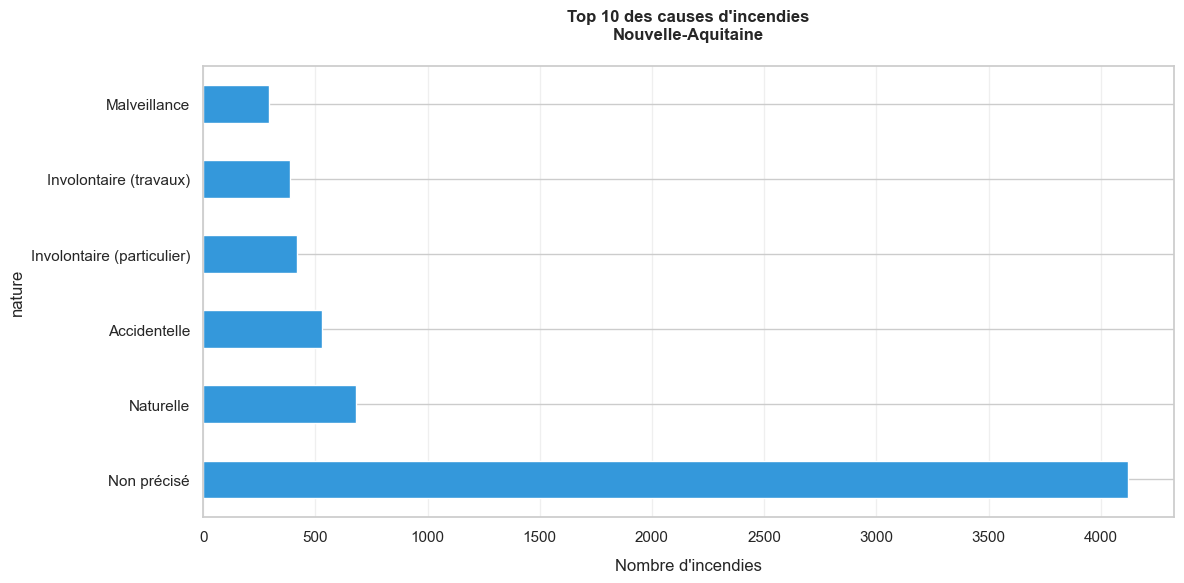


● Évolution temporelle des causes


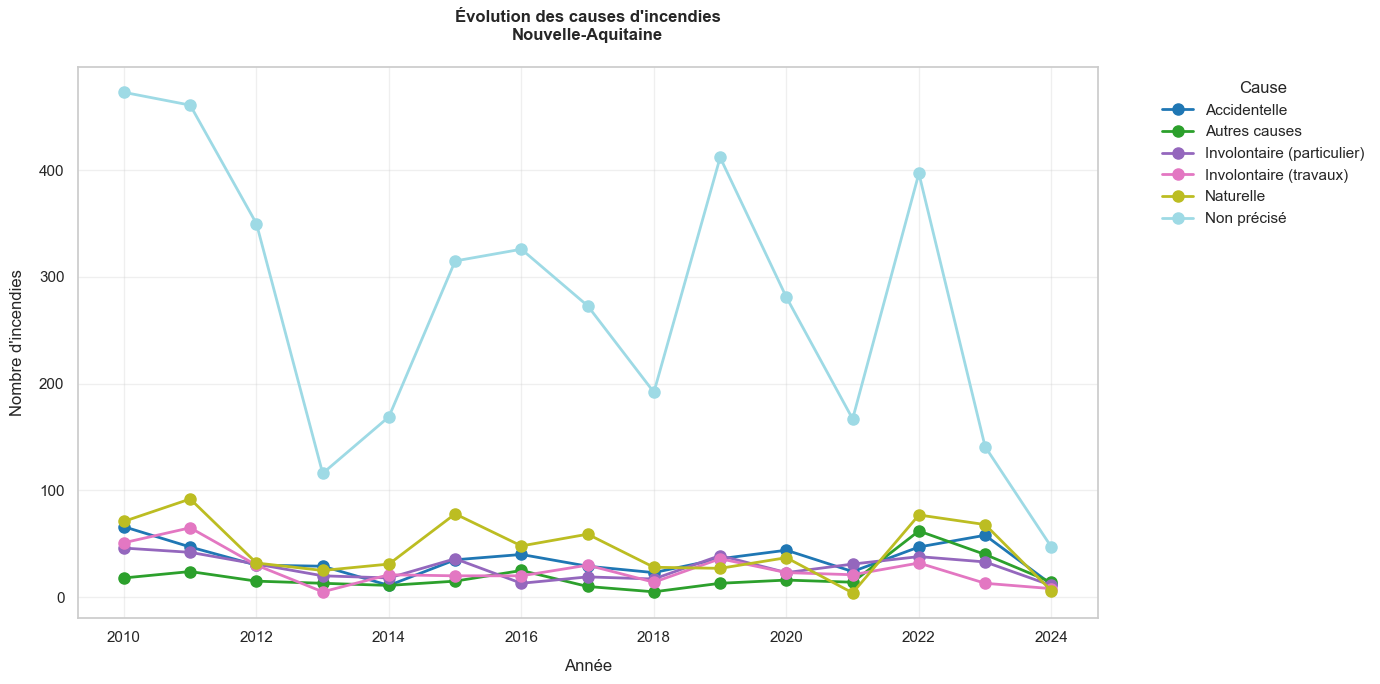

In [31]:
causes_na = analyser_causes_incendies(df_inc_na, "Nouvelle-Aquitaine")

Comprendre l'origine des incendies est fondamental pour orienter les politiques de prévention. Cette analyse se penche sur les causes des 6 435 incendies recensés en Nouvelle-Aquitaine. Cependant, une limite majeure de l'analyse doit être soulignée d'emblée : la grande majorité des causes reste non déterminée dans les données disponibles.

### **Répartition Générale des Causes**
La principale conclusion de cette analyse est le poids écrasant des causes non identifiées.

- **Cause principale** : Non précisé
  - 4 120 incendies, soit 64% du total, n'ont pas de cause assignée. Cette absence d'information limite fortement la portée des conclusions sur les autres catégories.

Parmi les causes identifiées, la répartition est la suivante :
- **Naturelle** : 683 incendies. Il s'agit principalement des feux déclenchés par la foudre. C'est la première cause identifiée dans la région.
- **Accidentelle** : 531 incendies.
- **Involontaire (particulier)** : 417 incendies. Regroupe les feux liés aux activités de loisirs, aux feux domestiques mal maîtrisés, etc.
- **Involontaire (travaux)** : 389 incendies. Concerne les feux liés aux activités agricoles, forestières ou industrielles.
- **Malveillance** : 295 incendies. Représente les feux allumés intentionnellement. C'est la cause identifiée la moins fréquente.

### **Évolution Temporelle des Causes**
Le graphique d'évolution temporelle montre que la courbe des causes "Non précisé" suit globalement la tendance du nombre total d'incendies par année, ce qui est logique puisqu'elle en constitue la majorité.

- **Causes Naturelles** : On observe des pics de feux d'origine naturelle certaines années, comme en 2011, 2015, 2017 et surtout en 2022, ce qui peut correspondre à des étés avec une forte activité orageuse.
- **Causes Humaines (Accidentelles, Involontaires, Malveillance)** : Ces causes montrent une certaine stabilité dans le temps, sans pic aussi marqué que les causes naturelles, bien qu'une légère hausse soit visible en 2022, année exceptionnelle pour les incendies.

### **Synthèse et Conclusion**
- **Le grand flou des origines** : Avec 64% de causes non précisées, il est difficile de dresser un portrait définitif des origines des feux en Nouvelle-Aquitaine. L'amélioration de la recherche et de la qualification des causes (RC) est un enjeu majeur pour affiner la prévention.
- **L'importance des causes naturelles** : Parmi les causes connues, l'origine naturelle (foudre) est la plus fréquente. Cela distingue la région et souligne l'importance de la surveillance des massifs forestiers lors des orages secs.
- **Un poids non négligeable des causes humaines** : Additionnées, les causes humaines (accidentelles, involontaires, malveillance) représentent un volume significatif d'incendies (plus de 1600 feux). Les actions de sensibilisation auprès du public et des professionnels (agriculteurs, forestiers) restent donc primordiales.

En conclusion, si la foudre est une cause naturelle prépondérante et difficilement maîtrisable, une part importante des incendies reste d'origine humaine et pourrait être évitée. L'effort doit porter à la fois sur la sensibilisation pour réduire les feux involontaires et sur l'investigation pour mieux comprendre et qualifier l'origine de la majorité des incendies aujourd'hui classés "non précisés".


### 9. Analyse des Causes des Incendies pour la Provence-Alpes-Côte d'Azur


=== ANALYSE DES CAUSES - PROVENCE-ALPES-CÔTE D'AZUR ===

● Statistiques générales


,Valeur
Nombre total d'incendies,7530
Causes non précisées,0
Pourcentage causes non précisées,0.0%



● Répartition des causes


,Nombre d'incendies
nature,
Non précisé,2188
Involontaire (particulier),1944
Malveillance,1547
Accidentelle,677
Involontaire (travaux),655
Naturelle,519



Cause principale: 'Non précisé' (2188 incendies, 29.1%)


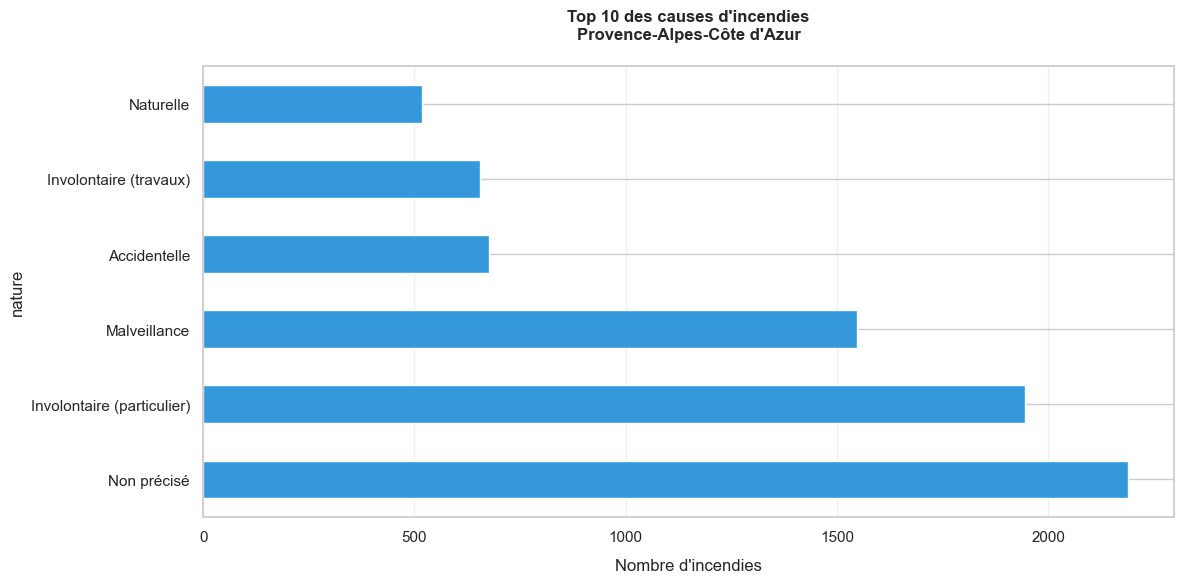


● Évolution temporelle des causes


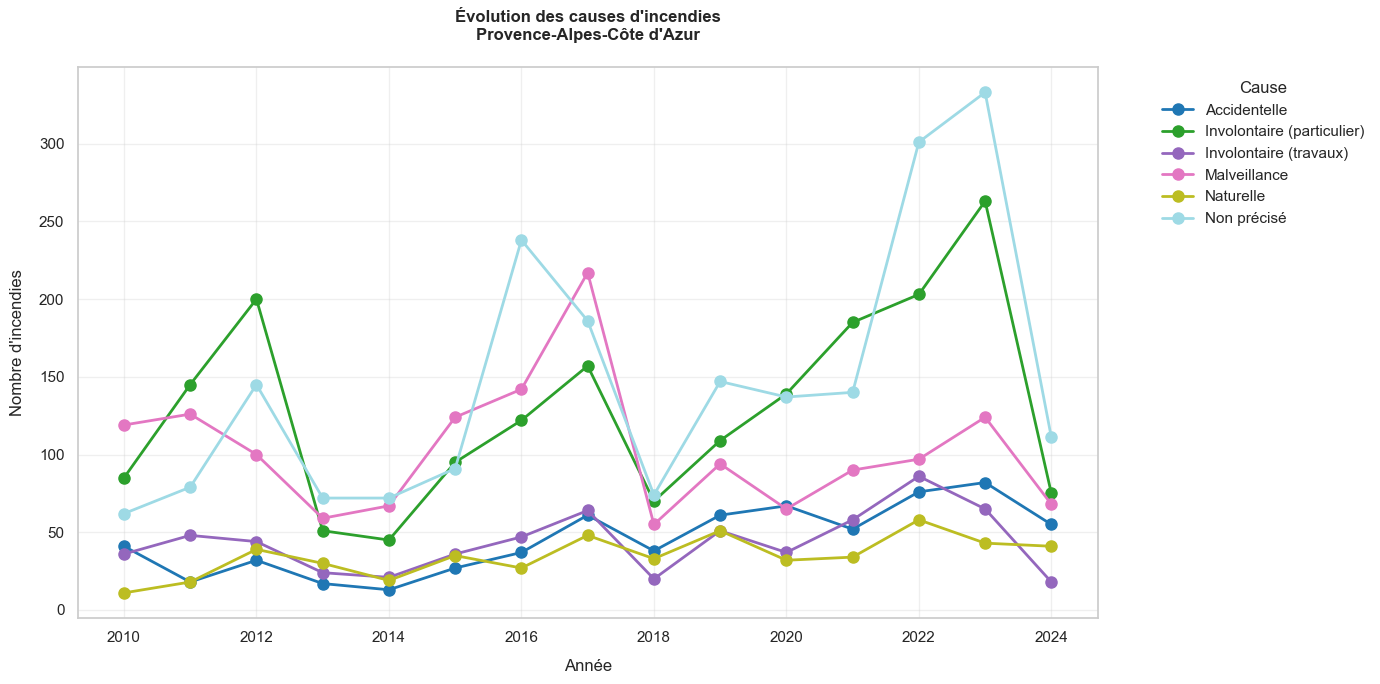

In [32]:
causes_paca = analyser_causes_incendies(df_inc_paca, "Provence-Alpes-Côte d'Azur")

Cette analyse se concentre sur les origines des 7 530 incendies survenus en région Provence-Alpes-Côte d'Azur. Contrairement à la Nouvelle-Aquitaine, la part des causes non précisées est bien plus faible, permettant de dégager un portrait plus clair et alarmant de l'influence humaine dans le déclenchement des feux dans cette région.

### **Répartition Générale des Causes
En PACA, les causes humaines dominent très largement le paysage des origines d'incendies.

- **Part des causes non précisées** : 2 188 incendies, soit 29,1%. Bien que ce chiffre reste important, il est plus de deux fois inférieur à celui de la Nouvelle-Aquitaine, rendant les autres catégories plus représentatives.

La hiérarchie des causes identifiées est radicalement différente :
- **Involontaire (particulier)** : 1 944 incendies. C'est la première cause identifiée et la plus fréquente. Elle est directement liée à l'imprudence (barbecues, mégots, etc.), exacerbée par la forte pression touristique et la densité de population.
- **Malveillance** : 1 547 incendies. La deuxième cause la plus fréquente, ce qui est un fait majeur. Le nombre de feux allumés intentionnellement est plus de cinq fois supérieur à celui de la Nouvelle-Aquitaine.
- **Accidentelle** : 677 incendies.
- **Involontaire (travaux)** : 655 incendies.
- **Naturelle** : 519 incendies. La foudre est la cause identifiée la moins fréquente en PACA.

### **Évolution Temporelle des Causes**
Le graphique d'évolution met en lumière des tendances inquiétantes pour les causes humaines.

- **Causes Involontaires (particulier)** : Cette cause montre une tendance à la hausse sur la période, avec des pics très nets en 2012, 2017 et surtout en 2023. Elle semble fortement corrélée aux années de forte sécheresse et/ou de forte fréquentation.
- **Malveillance** : La courbe de la malveillance montre également des pics alarmants, notamment en 2017 et 2021, suggérant des vagues d'actes criminels coïncidant avec des périodes de risque élevé.
- **Causes Naturelles** : À l'inverse, les causes naturelles restent relativement stables et à un niveau bas tout au long de la période.

### **Synthèse et Conclusion**
- **Une origine très majoritairement humaine** : En PACA, le feu est avant tout un phénomène d'origine humaine. En additionnant les causes involontaires, accidentelles et la malveillance, on constate que plus de 60% des incendies sont directement liés à l'activité humaine.
- **Le fléau de la malveillance** : La part exceptionnellement élevée des incendies volontaires (1 547 feux) est une caractéristique majeure et préoccupante de la région. Elle nécessite une réponse non seulement en termes de prévention, mais aussi de surveillance et de répression.
- **L'imprudence, premier facteur de risque** : La cause la plus fréquente reste l'imprudence des particuliers. Cela confirme que la sensibilisation du grand public et des touristes aux gestes à risque est le levier de prévention le plus important.

En conclusion, si le climat et la végétation de la région PACA créent un terrain propice aux incendies, ce sont bien les actions humaines, qu'elles soient involontaires ou criminelles, qui en sont le principal déclencheur. La lutte contre les incendies dans cette région passe donc inévitablement par une action massive sur les comportements humains.

---


### 10. Comparaison des Causes d’Incendies entre Régions

Cette section présente une analyse comparative des causes d’incendies entre les deux principales régions étudiées : Nouvelle-Aquitaine et PACA.

### a. Objectif

Comparer les types de causes les plus fréquentes dans chaque région, afin de mettre en évidence des tendances spécifiques ou des similitudes dans les déclencheurs d’incendies.

### b. Méthodologie

- Les jeux de données des deux régions ont été combinés dans un même DataFrame avec une colonne supplémentaire `region`.
- Les valeurs de la colonne `nature` (cause présumée) ont été nettoyées : espaces supprimés, valeurs vides converties en NaN.
- L’analyse s’est concentrée sur les 10 causes les plus fréquentes, communes aux deux régions.
- Un tableau croisé indique la fréquence de chaque cause par région.
- Un graphique à barres horizontales permet une visualisation claire de cette comparaison.

### c. Résultats

Le top 10 des causes d’incendie est extrait et comparé entre les régions. Les différences ou similarités dans les proportions par cause peuvent mettre en évidence des facteurs de risques propres à chaque région (ex. : activité humaine, aléas naturels, imprudences...).

### d. Visualisation

Le graphique généré illustre les causes les plus représentées avec un code couleur par région :

- **Nouvelle-Aquitaine** : Bleu
- **PACA** : Rouge

In [33]:
# === COMPARAISON DES CAUSES ENTRE RÉGIONS ===
def analyser_comparaison_causes(df_na, df_paca):
    """Analyse comparative des causes entre les deux régions"""
    results = {
        'dataframes': {},
        'figures': {},
        'graphiques_sauvegardes': {}
    }
    
    print("\n\033[1m=== COMPARAISON DES CAUSES ENTRE RÉGIONS ===\033[0m")
    
    # Préparation des données
    df_na['region'] = 'Nouvelle-Aquitaine'
    df_paca['region'] = 'PACA'
    df_combined = pd.concat([df_na, df_paca])
    
    # Nettoyage des causes
    df_combined['nature'] = df_combined['nature'].str.strip().replace('', np.nan)
    
    # Top 10 des causes communes
    top_causes = df_combined['nature'].value_counts().head(10).index
    results['dataframes']['top_causes_communes'] = df_combined[df_combined['nature'].isin(top_causes)]\
        .groupby(['region', 'nature']).size().unstack().T
    
    print("\n● TOP 10 DES CAUSES COMMUNES")
    display(results['dataframes']['top_causes_communes'])
    
    # Visualisation
    fig, ax = plt.subplots(figsize=(14, 8))
    sns.countplot(data=df_combined[df_combined['nature'].isin(top_causes)], 
                 y='nature', hue='region', 
                 order=top_causes,
                 palette=['#3498db', '#e74c3c'],
                 ax=ax)
    
    ax.set_title('Top 10 des causes d\'incendies par région', pad=20)
    ax.set_xlabel('Nombre d\'incendies', labelpad=10)
    ax.set_ylabel('Cause', labelpad=10)
    ax.legend(title='Région')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    
    results['figures']['comparaison_causes'] = fig
    results['graphiques_sauvegardes']['comparaison_causes'] = sauvegarder_graphique(fig, "comparaison_causes_regions")
    plt.show()
    
    return results


=== COMPARAISON DES CAUSES ENTRE RÉGIONS ===

● TOP 10 DES CAUSES COMMUNES


region,Nouvelle-Aquitaine,PACA
nature,,
Accidentelle,531,677
Involontaire (particulier),417,1944
Involontaire (travaux),389,655
Malveillance,295,1547
Naturelle,683,519
Non précisé,4120,2188


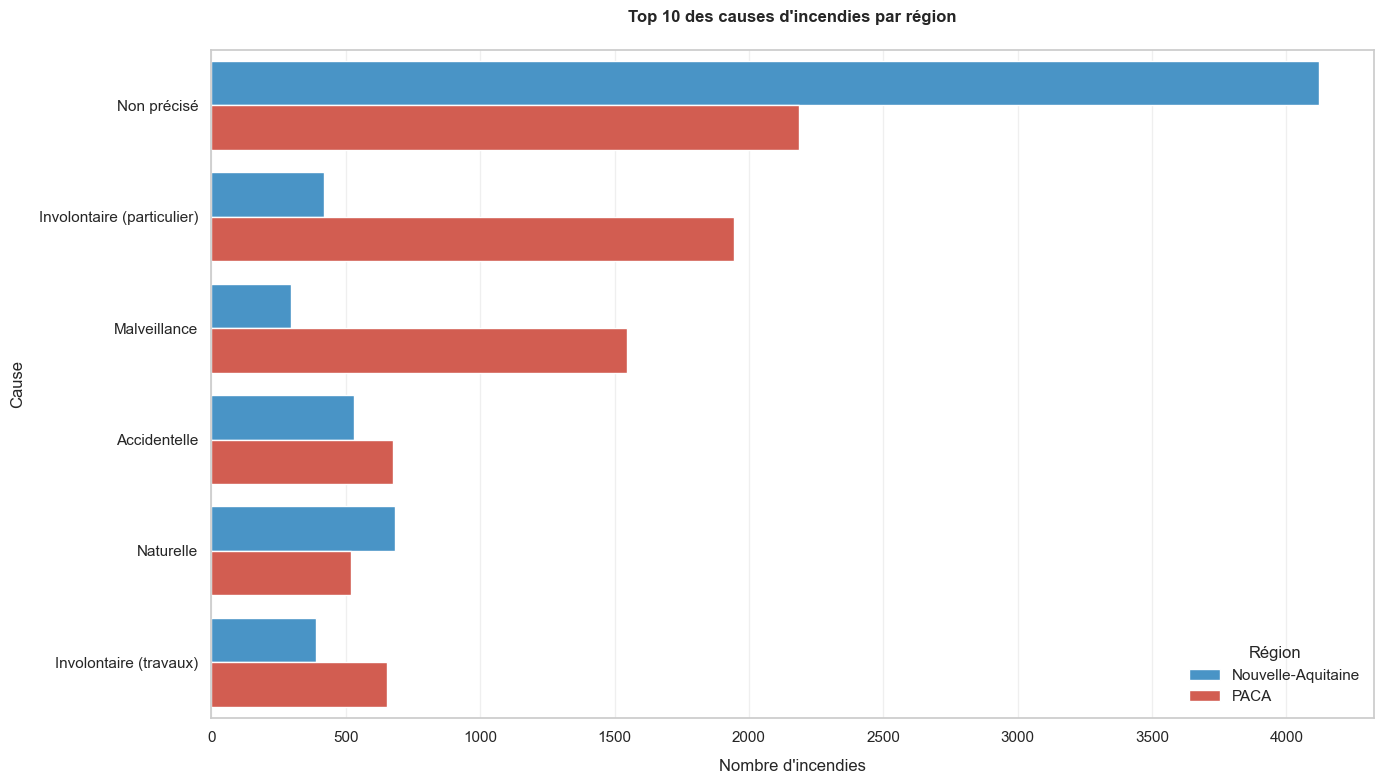

In [34]:
comparaison_causes = analyser_comparaison_causes(df_inc_na, df_inc_paca)

La comparaison directe des causes d'incendies entre la Nouvelle-Aquitaine et la région Provence-Alpes-Côte d'Azur révèle deux profils de risque radicalement différents. Alors que les deux régions sont fortement touchées par les incendies, les facteurs déclenchants varient de manière spectaculaire, ce qui impose des stratégies de prévention et de lutte distinctes.

### **Analyse Comparative**
Le graphique et le tableau mettent en évidence des divergences fondamentales :

### Causes Humaines (Involontaire & Malveillance)
- **Région PACA** : C'est le point de rupture le plus évident. Les causes humaines y sont prédominantes.
  - **Involontaire (particulier)** : Près de 2 000 cas en PACA, soit 4,5 fois plus qu'en Nouvelle-Aquitaine. C'est la première cause de feu dans la région, liée à la forte densité de population et au tourisme.
  - **Malveillance** : Plus de 1 500 cas en PACA, soit 5 fois plus qu'en Nouvelle-Aquitaine. La malveillance est un fléau majeur et une caractéristique propre au risque incendie en PACA.

- **Nouvelle-Aquitaine** : Les causes humaines sont présentes mais dans des proportions bien moindres.

### Causes Naturelles (Foudre)
- **Nouvelle-Aquitaine** : La cause naturelle est la première cause identifiée (683 cas). Le risque lié à la foudre, notamment dans le massif landais, est une composante structurelle du risque dans cette région.
- **Région PACA** : La cause naturelle est la moins fréquente des causes identifiées (519 cas).

### Causes "Non précisées"
- **Nouvelle-Aquitaine** : Le nombre de causes non précisées est extrêmement élevé (4 120 cas, 64% du total), ce qui rend l'analyse plus difficile et suggère un enjeu dans la recherche et la qualification des causes après incendie.
- **Région PACA** : Bien qu'encore important (2 188 cas), ce chiffre est proportionnellement beaucoup plus faible (29% du total), donnant une image plus claire de la répartition des causes.

**Graphique** : Comparaison du nombre d'incendies par cause et par région.

### **Synthèse et Conclusion : Deux Profils de Risque Distincts**

| Caractéristique                   | Nouvelle-Aquitaine                       | Provence-Alpes-Côte d'Azur (PACA)    |
|-----------------------------------|-----------------------------------------|---------------------------------------|
| **Origine Principale du Risque**  | Principalement naturelle (foudre) et indéterminée. | Très majoritairement humaine (imprudence et malveillance). |
| **Cause Humaine Dominante**       | Accidentelle / Involontaire (équilibré). | Involontaire (particulier), de très loin. |
| **Poids de la Malveillance**      | Faible.                                | Très élevé, un facteur de risque majeur. |
| **Enjeu Principal**               | Améliorer la qualification des causes et gérer le risque foudre. | Lutter contre l'imprudence et la criminalité. |

En conclusion, la comparaison dresse le portrait de deux réalités :
- La Nouvelle-Aquitaine fait face à un risque où les phénomènes naturels (foudre) jouent un rôle prépondérant parmi les causes connues, mais où une grande partie des origines reste un angle mort.
- La région PACA est, quant à elle, confrontée à un risque dont l'origine est sans équivoque humaine. La prévention doit y cibler en priorité les comportements (imprudence) et la surveillance doit intégrer une forte composante de lutte contre les actes de malveillance.

---

### 11. Analyse des Grands Incendies

Cette section est dédiée à l’étude des grands incendies, définis comme ceux dont la surface brûlée dépasse un seuil de quantile (par défaut : 95e percentile). L’objectif est d’identifier les principales causes, zones géographiques et tendances temporelles associées à ces événements extrêmes.

### a. Objectif

Mettre en évidence les caractéristiques des feux les plus dévastateurs pour chaque région, afin de mieux comprendre les dynamiques des incendies majeurs et leurs origines probables.

### b. Méthodologie

- **Filtrage des incendies majeurs** : seuls les incendies dépassant le quantile spécifié (surface_ha >= P95) sont conservés.
  
- **Calculs statistiques** :
  - Nombre de feux par cause (nature)
  - Surface moyenne et maximale par cause
  - Commune la plus fréquemment touchée pour chaque cause

- **Visualisation temporelle** :
  - Histogramme empilé des grands incendies par année et par cause (nature)
  - Permet de détecter des tendances ou pics anormaux dans le temps

### c. Résultats produits

- **Tableau statistique** : résumé des grandes causes avec surfaces moyennes/max et commune la plus touchée.
- **Graphique** : évolution annuelle du nombre de grands incendies, répartis selon leur cause.

### d. Exemple de seuil

Seuil utilisé par défaut : 95e percentile. Ce seuil est personnalisable dans la fonction (seuil=0.95).

### e. Structure de sortie

La fonction retourne un dictionnaire contenant :

- `dataframes['stats_grands_feux']` : tableau statistique par cause
- `figures['evolution_grands_feux']` : figure matplotlib
- `graphiques_sauvegardes` : chemin de sauvegarde de l’image


In [35]:
# === ANALYSE DES GRANDS INCENDIES ===
def analyse_grands_feux(df, region, seuil=0.95):
    """Analyse des grands incendies (au-dessus du seuil spécifié)"""
    results = {
        'region': region,
        'dataframes': {},
        'figures': {},
        'graphiques_sauvegardes': {}
    }
    
    if 'surface_ha' not in df.columns:
        return results
    
    seuil_quantile = df['surface_ha'].quantile(seuil)
    grands_feux = df[df['surface_ha'] >= seuil_quantile]
    
    print(f"\n\033[1m=== GRANDS INCENDIES (>P{int(seuil*100)}) - {region.upper()} ===\033[0m")
    
    # Statistiques par cause
    stats_grands_feux = grands_feux.groupby('nature').agg({
        'surface_ha': ['count', 'mean', 'max'],
        'nom_de_la_commune': lambda x: x.mode()[0]
    })
    
    stats_grands_feux.columns = ['Nombre', 'Surface moyenne (ha)', 'Surface max (ha)', 'Commune la plus fréquente']
    results['dataframes']['stats_grands_feux'] = stats_grands_feux
    
    display(results['dataframes']['stats_grands_feux'])
    
    # Visualisation temporelle
    if 'année' in df.columns and 'nature' in df.columns:
        fig, ax = plt.subplots(figsize=(12, 5))
        grands_feux.groupby('année')['nature'].value_counts().unstack().plot(
            kind='bar', stacked=True, ax=ax)
        ax.set_title(f"Évolution des grands incendies par cause\n({region})")
        ax.set_xlabel('Année')
        ax.set_ylabel('Nombre de grands incendies')
        plt.tight_layout()
        
        results['figures']['evolution_grands_feux'] = fig
        results['graphiques_sauvegardes']['evolution_grands_feux'] = sauvegarder_graphique(fig, f"evolution_grands_feux_{region}")
        plt.show()
    
    return results

### 11. Analyse des Grands Incendies de la Nouvelle-Aquitaine


=== GRANDS INCENDIES (>P95) - NOUVELLE-AQUITAINE ===


,Nombre,Surface moyenne (ha),Surface max (ha),Commune la plus fréquente
nature,,,,
Accidentelle,29,24.095128,111.000,Hostens
Involontaire (particulier),21,51.882381,491.600,Beylongue
Involontaire (travaux),38,32.812884,381.000,Agonac
Malveillance,19,910.451053,12552.000,La Roche-Chalais
Naturelle,12,18.286508,41.393,Beylongue
Non précisé,220,95.160686,6742.700,Chauvigny


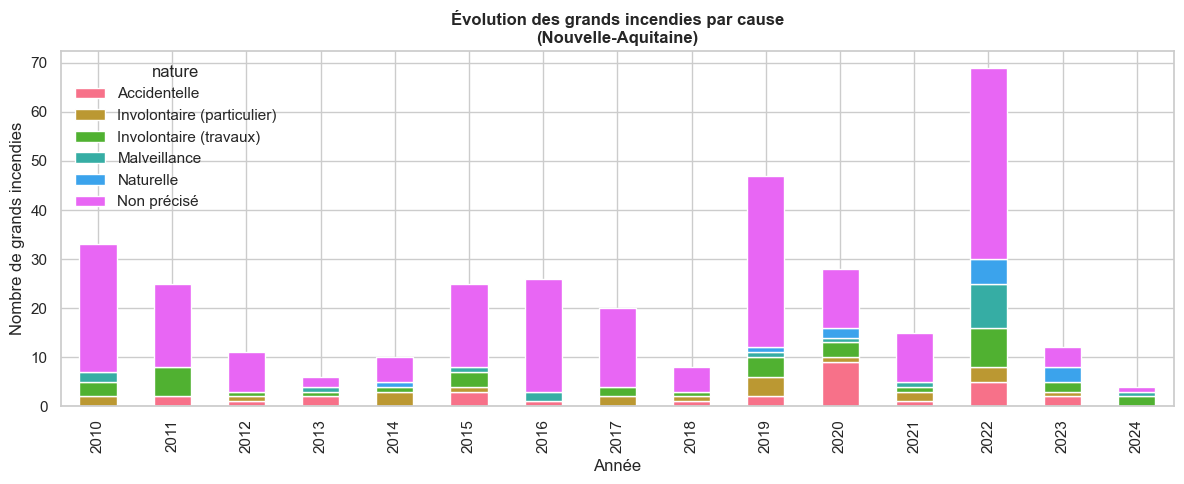

In [36]:
grands_feux_na = analyse_grands_feux(df_inc_na, "Nouvelle-Aquitaine")

Si la majorité des feux sont rapidement maîtrisés, ce sont les "grands incendies" qui façonnent le paysage, causent le plus de dégâts et mobilisent le plus de moyens. Cette analyse se concentre sur les 5% des incendies les plus étendus en région PACA pour comprendre leurs origines spécifiques et leur dynamique.

### **Quelles sont les causes des plus grands feux ?**
En se focalisant sur les incendies majeurs, la hiérarchie des causes change, révélant les origines des événements les plus critiques.

- **Malveillance** : 99 grands incendies. C'est la première cause de grands feux en PACA. Non seulement les actes de malveillance sont fréquents, mais ils sont aussi les plus susceptibles de dégénérer en incendies de grande ampleur.
- **Involontaire (particulier)** : 88 grands incendies. L'imprudence des particuliers est la deuxième cause de feux majeurs, confirmant que des gestes anodins peuvent avoir des conséquences catastrophiques.
- **Non précisé** : 78 grands incendies.
- **Involontaire (travaux)** : 63 grands incendies.
- **Accidentelle** : 34 grands incendies.
- **Naturelle** : 15 grands incendies. Fait notable, la foudre est la cause qui génère le moins de grands incendies.

Le graphique d'évolution temporelle montre des pics dramatiques de grands incendies, notamment en 2017 (dominé par la malveillance et l'imprudence) et en 2022 (dominé par les causes involontaires et accidentelles).

## **Quelle cause est la plus destructrice ?**
Analyser la surface moyenne brûlée par les grands incendies permet de mesurer le potentiel de destruction de chaque cause.

- **Involontaire (particulier)** : 155 ha en moyenne. C'est la cause qui produit les incendies les plus vastes. Le feu majeur le plus étendu de la période (6 832 ha) est issu de cette catégorie, probablement sur la commune de Martigues.
- **Naturelle** : 130 ha en moyenne. Bien que rares, les grands feux de foudre sont très destructeurs.
- **Accidentelle** : 90 ha en moyenne.
- **Malveillance** : 79 ha en moyenne.
- **Involontaire (travaux)** : 63 ha en moyenne.

Il est intéressant de noter que si la malveillance provoque le plus grand nombre de grands feux, c'est bien l'imprudence des particuliers qui génère les feux les plus étendus en moyenne.

## **Synthèse et Conclusion**
- **Les causes humaines au cœur des catastrophes** : L'analyse des grands feux confirme et amplifie la conclusion précédente : les événements les plus dévastateurs en PACA sont quasi exclusivement d'origine humaine. La malveillance et l'imprudence des particuliers sont responsables du plus grand nombre de feux majeurs.
- **L'imprudence, un potentiel destructeur maximal** : Les feux issus de l'imprudence des particuliers sont non seulement fréquents, mais ce sont aussi eux qui deviennent les plus grands monstres, avec une surface moyenne brûlée de plus de 150 hectares.
- **Des années noires** : Les années 2017 et 2022 se distinguent comme des années de crises majeures, concentrant un nombre très élevé de grands incendies d'origine humaine.

En conclusion, la stratégie de lutte contre les grands incendies en PACA doit être agressivement ciblée sur les causes humaines. La prévention de l'imprudence est le levier le plus puissant pour réduire la surface moyenne brûlée, tandis que la lutte contre la malveillance est essentielle pour diminuer le nombre de départs de feux à haut potentiel de propagation.


### 11. Analyse des Grands Incendies de la Provence-Alpes-Côte d'Azur


=== GRANDS INCENDIES (>P95) - PROVENCE-ALPES-CÔTE D'AZUR ===


,Nombre,Surface moyenne (ha),Surface max (ha),Commune la plus fréquente
nature,,,,
Accidentelle,34,90.197559,1451.53,Aiguines
Involontaire (particulier),88,154.789874,6832.00,Martigues
Involontaire (travaux),63,62.967000,2500.00,Bayons
Malveillance,99,78.833117,1704.00,Lantosque
Naturelle,15,129.685167,1141.81,Aiguines
Non précisé,78,69.723706,959.51,Lantosque


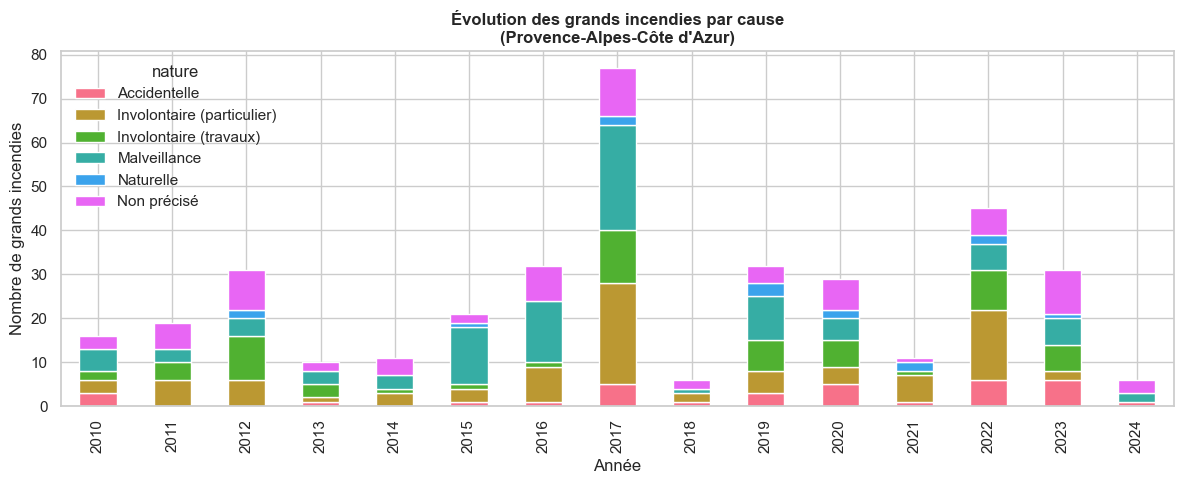

In [37]:
grands_feux_paca = analyse_grands_feux(df_inc_paca, "Provence-Alpes-Côte d'Azur")

### 12. Analyse des Décès Liés aux Incendies

Cette section vise à identifier et analyser les incendies ayant entraîné des décès humains. L’analyse se concentre sur la fréquence, la répartition temporelle et les relations avec d’autres variables clés comme la surface brûlée ou la nature de l’incendie.

### a. Méthodologie

- **Filtrage** : Seuls les incendies ayant un nombre de décès strictement supérieur à 0 sont conservés.

- **Statistiques** :
  - Nombre total d’incendies mortels.
  - Répartition des décès par année, ainsi que la cause principale pour chaque année (issue de la variable nature).

- **Visualisation** :
  - Une figure de dispersion est générée pour visualiser la relation entre la surface parcourue par le feu et le nombre de décès, avec :
    - La cause de l’incendie en couleur (hue = nature).
    - Le nombre de décès en taille (size = nombre_de_décès).

### b. Points Clés du Traitement

- Si la colonne `nombre_de_décès` est absente, l’analyse est ignorée.
- En présence de données valides :
  - Un tableau est généré avec la somme des décès par année et la cause la plus fréquente par an.
  - Un graphique de corrélation surface/décès est affiché, sauvegardé automatiquement pour archivage.

### c. Intérêt de l’Analyse

Cette analyse permet d’identifier les années particulièrement meurtrières, les contextes (nature des feux) associés aux décès, ainsi que les liens éventuels entre la gravité (en surface) et les pertes humaines.


In [38]:
# === ANALYSE DES DÉCÈS ===
def analyse_deces(df, region):
    """Analyse des incendies ayant causé des décès"""
    results = {
        'region': region,
        'dataframes': {},
        'figures': {},
        'graphiques_sauvegardes': {}
    }
    
    if 'nombre_de_décès' not in df.columns:
        return results
    
    # Filtre des incendies avec décès
    df_deces = df[df['nombre_de_décès'] > 0]
    nb_incendies_avec_deces = len(df_deces)
    
    print(f"\n\033[1m=== ANALYSE DES DÉCÈS - {region.upper()} ===\033[0m")
    print(f"Nombre d'incendies ayant causé des décès: {nb_incendies_avec_deces}")
    
    if nb_incendies_avec_deces > 0:
        # Détail par année et cause
        deces_par_annee = df_deces.groupby('année').agg({
            'nombre_de_décès': 'sum',
            'nature': lambda x: x.mode()[0]
        })
        deces_par_annee.columns = ['Nombre de décès', 'Cause principale']
        
        results['dataframes']['deces_par_annee'] = deces_par_annee
        print("\nRépartition par année:")
        display(results['dataframes']['deces_par_annee'])
        
        # Relation avec la surface
        if 'surface_parcourue_(m2)' in df.columns:
            fig, ax = plt.subplots(figsize=(10, 5))
            sns.scatterplot(data=df_deces, 
                           x='surface_parcourue_(m2)', 
                           y='nombre_de_décès',
                           hue='nature',
                           size='nombre_de_décès',
                           sizes=(50, 200),
                           ax=ax)
            ax.set_title(f"Relation surface/décès\n({region})")
            ax.set_xlabel("Surface brûlée (m²)")
            ax.set_ylabel("Nombre de décès")
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            
            results['figures']['relation_surface_deces'] = fig
            results['graphiques_sauvegardes']['relation_surface_deces'] = sauvegarder_graphique(fig, f"relation_surface_deces_{region}")
            plt.show()
    
    return results

### 12.1. Analyse des Décès pour la Nouvelle-Aquitaine


=== ANALYSE DES DÉCÈS - NOUVELLE-AQUITAINE ===
Nombre d'incendies ayant causé des décès: 1

Répartition par année:


,Nombre de décès,Cause principale
année,,
2024,1,Involontaire (travaux)


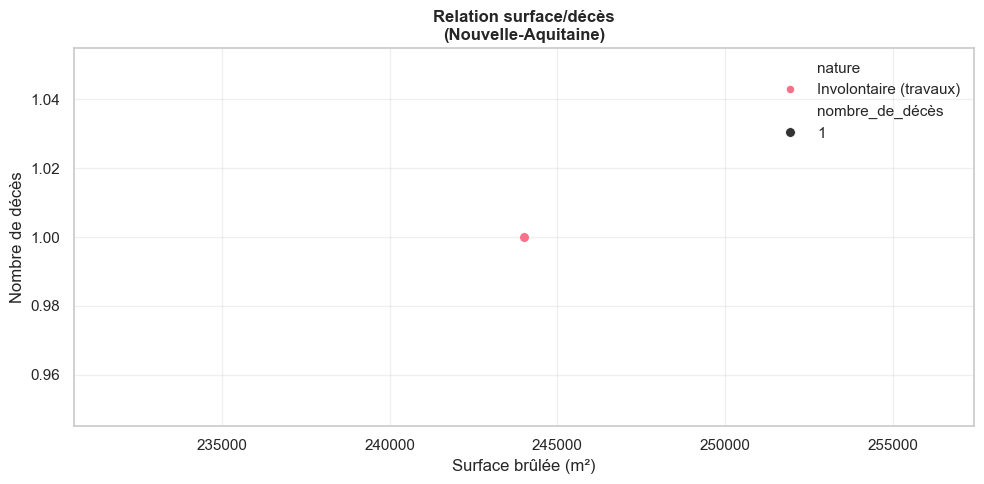

In [39]:
deces_na = analyse_deces(df_inc_na, "Nouvelle-Aquitaine")

### 12.2. Analyse des Décès pour la Provence-Alpes-Côte d'Azur


=== ANALYSE DES DÉCÈS - PROVENCE-ALPES-CÔTE D'AZUR ===
Nombre d'incendies ayant causé des décès: 1

Répartition par année:


,Nombre de décès,Cause principale
année,,
2023,1,Accidentelle


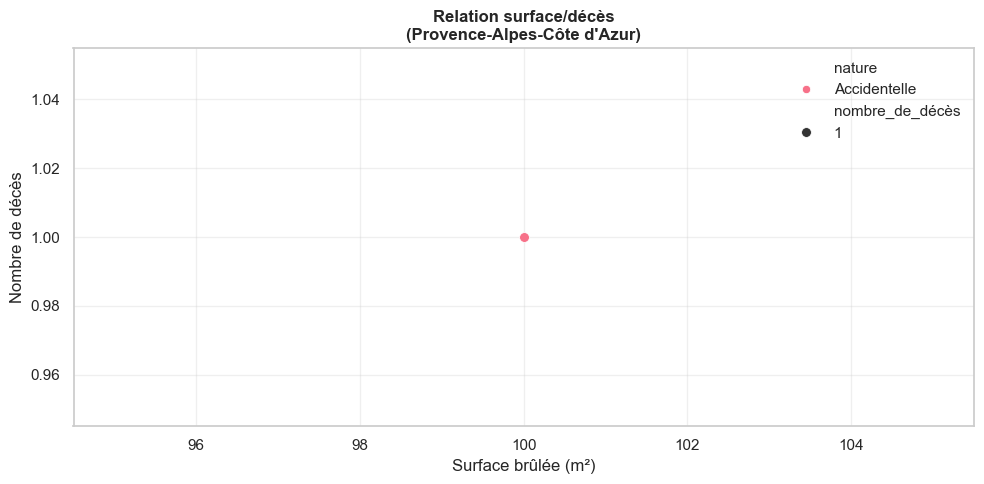

In [40]:
deces_paca = analyse_deces(df_inc_paca, "Provence-Alpes-Côte d'Azur")

### 13. Analyse Combinée : Décès et Bâtiments Détruits

Cette analyse vise à identifier les incendies les plus graves, caractérisés par la survenue de décès ou la destruction totale de bâtiments. L’objectif est de mieux comprendre la gravité de certains sinistres en croisant plusieurs indicateurs d’impact humain et matériel.

### a. Méthodologie

### **Filtrage des événements** :
Seuls les incendies avec :
- un nombre de décès > 0, ou
- un nombre de bâtiments totalement détruits > 0

sont conservés pour cette analyse.

### **Statistiques descriptives** :
- Surface totale brûlée (`surface_parcourue_(m2)`)
- Nombre de décès
- Nombre de bâtiments détruits

### **Visualisation géographique** :
Une carte localise les incendies graves avec :
- La taille des points représentant le nombre de bâtiments détruits
- La couleur des points reflétant le nombre de décès
- Un fond de carte neutre pour faciliter la lecture

### b. Résultats attendus

- Nombre total d’incendies graves recensés pour la région.
- Tableau statistique présentant les moyennes, minimums, maximums et autres indicateurs pour les colonnes clés.
- Carte des localisations des incendies graves, utile pour détecter d’éventuels regroupements géographiques ou zones à risque élevé.

### **Remarque**

L’analyse dépend fortement de la qualité et de l’exhaustivité des données sur les décès et les destructions de bâtiments. Toute absence de ces valeurs dans la base peut sous-estimer la gravité réelle de certains événements.


In [41]:
# === ANALYSE COMBINÉE (DÉCÈS ET BÂTIMENTS DÉTRUITS) ===
def analyse_combinee(df, region):
    """Analyse combinée des incendies graves (décès ou bâtiments détruits)"""
    results = {
        'region': region,
        'dataframes': {},
        'figures': {},
        'graphiques_sauvegardes': {}
    }
    
    # Vérification des colonnes nécessaires
    if 'nombre_de_décès' not in df.columns or 'nombre_de_bâtiments_totalement_détruits' not in df.columns:
        return results
    
    # Filtre des événements graves
    df_graves = df[(df['nombre_de_décès'] > 0) | 
                 (df['nombre_de_bâtiments_totalement_détruits'] > 0)]
    
    print(f"\n\033[1m=== ANALYSE COMBINÉE - {region.upper()} ===\033[0m")
    print(f"Nombre d'incendies graves: {len(df_graves)}")
    
    if len(df_graves) > 0:
        # Caractéristiques communes
        stats_graves = df_graves[['surface_parcourue_(m2)', 
                                'nombre_de_décès', 
                                'nombre_de_bâtiments_totalement_détruits']].describe()
        
        results['dataframes']['stats_incendies_graves'] = stats_graves
        print("\nCaractéristiques moyennes:")
        display(results['dataframes']['stats_incendies_graves'])
        
        # Carte de localisation
        if 'latitude' in df.columns and 'longitude' in df.columns:
            fig, ax = plt.subplots(figsize=(10, 8))
            sns.scatterplot(data=df_graves,
                           x='longitude',
                           y='latitude',
                           size='nombre_de_bâtiments_totalement_détruits',
                           hue='nombre_de_décès',
                           sizes=(20, 200),
                           palette='Reds',
                           ax=ax)
            ax.set_title(f"Localisation des incendies graves\n({region})")
            ax.legend(title='Gravité', bbox_to_anchor=(1.05, 1), loc='upper left')
            ax.grid(True, alpha=0.3)
            plt.tight_layout()
            
            results['figures']['localisation_incendies_graves'] = fig
            results['graphiques_sauvegardes']['localisation_incendies_graves'] = sauvegarder_graphique(fig, f"localisation_incendies_graves_{region}")
            plt.show()
    
    return results

### 13. Analyse Combinée : Décès et Bâtiments Détruits pour la Nouvelle-Aquitaine


=== ANALYSE COMBINÉE - NOUVELLE-AQUITAINE ===
Nombre d'incendies graves: 8

Caractéristiques moyennes:


,surface_parcourue_(m2),nombre_de_décès,nombre_de_bâtiments_totalement_détruits
count,8.000000,8.000000,8.000000
mean,140941.250000,0.125000,1.125000
std,297633.466649,0.353553,0.834523
min,30.000000,0.000000,0.000000
25%,3875.000000,0.000000,1.000000
50%,7500.000000,0.000000,1.000000
75%,72250.000000,0.000000,1.000000
max,848000.000000,1.000000,3.000000


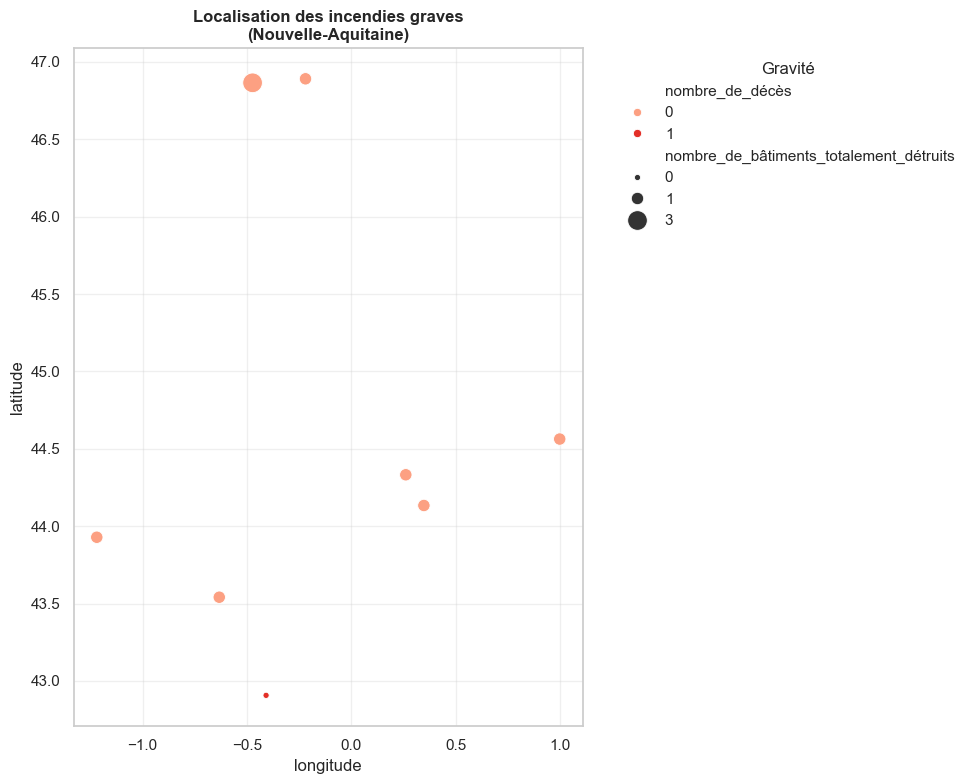

In [42]:
combinee_na = analyse_combinee(df_inc_na, "Nouvelle-Aquitaine")

### 13.2. Analyse Combinée : Décès et Bâtiments Détruits pour la Provence-Alpes-Côte d'Azur


=== ANALYSE COMBINÉE - PROVENCE-ALPES-CÔTE D'AZUR ===
Nombre d'incendies graves: 9

Caractéristiques moyennes:


,surface_parcourue_(m2),nombre_de_décès,nombre_de_bâtiments_totalement_détruits
count,9.000000,9.000000,9.0
mean,32785.555556,0.111111,1.0
std,82079.236581,0.333333,0.5
min,30.000000,0.000000,0.0
25%,100.000000,0.000000,1.0
50%,600.000000,0.000000,1.0
75%,15500.000000,0.000000,1.0
max,250400.000000,1.000000,2.0


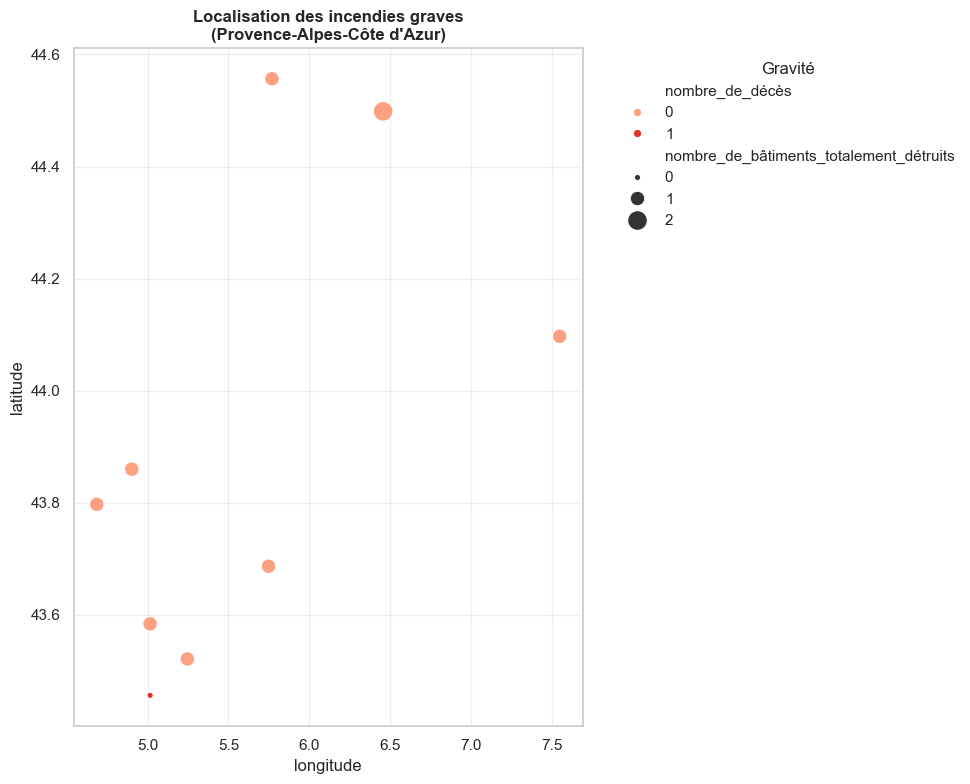

In [43]:
combinee_paca = analyse_combinee(df_inc_paca, "Provence-Alpes-Côte d'Azur")

### **Analyse des Incendies à Fort Impact : Nouvelle-Aquitaine vs. Provence-Alpes-Côte d'Azur**

Au-delà des surfaces parcourues, la gravité d'un incendie se mesure aussi à son impact humain et matériel. Cette analyse se concentre sur les événements les plus tragiques : ceux ayant causé des décès ou la destruction de bâtiments. Elle compare la situation entre la Nouvelle-Aquitaine et la région PACA pour identifier les caractéristiques de ces feux à fort impact.

### **Analyse des Décès**
Sur toute la période et pour l'ensemble des deux régions, les décès liés directement aux feux de végétation restent des événements heureusement très rares.

### Nouvelle-Aquitaine
- **Incendies mortels** : 1 seul incendie recensé.
  - **Date** : 2024
  - **Cause** : Involontaire (travaux)
  - **Surface parcourue** : Environ 24,5 ha

### Provence-Alpes-Côte d'Azur
- **Incendies mortels** : 1 seul incendie recensé.
  - **Date** : 2023
  - **Cause** : Accidentelle
  - **Surface parcourue** : Environ 100 m² (soit 0,01 ha)

Cette différence est fondamentale : en Nouvelle-Aquitaine, le décès est lié à un feu d'une certaine ampleur, tandis qu'en PACA, il est survenu sur un feu minime, suggérant un accident de proximité (par exemple, une personne surprise par les flammes en tentant d'éteindre un petit départ de feu).

### **Analyse des Incendies Graves (avec victimes ou bâtiments détruits)**
En combinant les incendies ayant causé des décès ou la destruction de bâtiments, on obtient un aperçu des feux ayant eu l'impact le plus direct sur les biens et les personnes.

| Caractéristique                     | Nouvelle-Aquitaine             | Provence-Alpes-Côte d'Azur     |
|-------------------------------------|--------------------------------|--------------------------------|
| **Nombre d'incendies graves**       | 8                              | 9                              |
| **Surface moyenne de ces feux**     | 140 941 m² (14,1 ha)          | 32 785 m² (3,3 ha)            |
| **Bâtiments détruits (moyenne)**    | 1,125                          | 1,0                            |
| **Bâtiments détruits (max)**        | 3                              | 2                              |

### Interprétation
- **Un nombre d'événements similaire** : Les deux régions ont connu un nombre comparable d'incendies à fort impact (8 en Nouvelle-Aquitaine, 9 en PACA).
- **Des surfaces très différentes** : Le point le plus marquant est la surface moyenne de ces incendies. En Nouvelle-Aquitaine, les feux qui détruisent des bâtiments sont en moyenne quatre fois plus grands que ceux en PACA. Cela suggère que le risque pour les habitations est lié à des feux de forêt d'une certaine ampleur qui viennent menacer les zones habitées.
- **Le risque en interface habitat-forêt** : En PACA, les destructions de bâtiments surviennent sur des feux en moyenne beaucoup plus petits. Cela illustre parfaitement le risque typique des zones d'interface habitat-forêt, où les habitations sont très proches de la végétation et peuvent être touchées par des feux de faible étendue.

Les cartes de localisation des incendies graves montrent visuellement cette dynamique : les points sont dispersés dans les zones à risque de chaque région, avec la taille des points indiquant le nombre de bâtiments détruits.

### **Synthèse et Conclusion**
- **Des drames heureusement rares** : Les incendies mortels sont exceptionnels dans les deux régions, mais leurs circonstances diffèrent (feu étendu vs. feu de proximité).
  
### Deux logiques de risque pour les habitations :
- **Nouvelle-Aquitaine** : Le danger pour les bâtiments provient principalement de grands feux de forêt qui avancent vers les zones bâties. La stratégie de protection repose donc sur le contrôle des grands feux.
  
- **Provence-Alpes-Côte d'Azur** : Le danger est plus diffus et lié à la proximité immédiate entre la végétation et les habitations. Même un petit feu peut rapidement détruire un bâtiment. La prévention passe donc par la gestion du combustible aux abords directs des maisons (débroussaillement, etc.).

Cette analyse finale souligne que même avec un nombre de victimes et de destructions heureusement limité, les dynamiques de risque sous-jacentes sont profondément différentes et appellent des réponses adaptées à la configuration de chaque territoire.

---


### 14. Extraction des Cas Graves d’Incendie

Cette section vise à identifier les incendies les plus graves en termes d’impact humain et matériel. Deux critères principaux sont pris en compte :

- **Présence de décès** (\(nombre\_de\_décès > 0\))
- **Destruction de bâtiments** (\(nombre\_de\_bâtiments\_totalement\_détruits > 0\))

### a. Objectifs de la Fonction

- Filtrer les incendies graves à partir d’un jeu de données régional.
- Générer deux tableaux triés pour mettre en lumière :
  - Les incendies avec la plus grande surface brûlée parmi les cas graves.
  - Les incendies ayant détruit le plus de bâtiments.

### b. Méthodologie

1. **Vérification des colonnes nécessaires** :
   - `nombre_de_décès`
   - `nombre_de_bâtiments_totalement_détruits`

2. **Filtrage** : Sélection des lignes répondant à l’un ou l’autre des critères de gravité.

3. **Tri et extraction** :
   - Par surface brûlée : classement décroissant selon `surface_parcourue_(m2)`
   - Par bâtiments détruits : classement décroissant selon `nombre_de_bâtiments_totalement_détruits`

### c. Résultat

Deux tableaux synthétiques :
- `cas_graves_surface` : contenant :
  - L’année
  - La commune
  - Le type de feu
  - La surface parcourue
  - Le nombre de décès
  - Le nombre de bâtiments détruits

- `cas_graves_batiments` : contenant les mêmes informations.

### Exemple de Résultat Affiché

- **Top 3 des incendies graves selon la surface parcourue**
- **Top 3 selon les destructions matérielles**

Ces tableaux permettent d’identifier les incidents les plus dévastateurs et d’orienter les analyses approfondies.


In [44]:
# === EXTRACTION DES CAS CONCRETS ===
def extraire_cas_graves(df, region):
    """Extraction des cas graves pour analyse détaillée"""
    results = {
        'region': region,
        'dataframes': {}
    }
    
    # Vérification des colonnes nécessaires
    if 'nombre_de_décès' not in df.columns or 'nombre_de_bâtiments_totalement_détruits' not in df.columns:
        return results
    
    # Extraction des cas graves
    cas_graves = df[(df['nombre_de_décès'] > 0) | 
                   (df['nombre_de_bâtiments_totalement_détruits'] > 0)]
    
    # Tri par surface et bâtiments détruits
    cas_graves_surface = cas_graves.sort_values('surface_parcourue_(m2)', ascending=False)\
        [['année', 'nom_de_la_commune', 'nature', 
          'surface_parcourue_(m2)', 'nombre_de_décès',
          'nombre_de_bâtiments_totalement_détruits']]
    
    cas_graves_batiments = cas_graves.sort_values('nombre_de_bâtiments_totalement_détruits', ascending=False)\
        [['année', 'nom_de_la_commune', 'nature',
          'surface_parcourue_(m2)', 'nombre_de_décès',
          'nombre_de_bâtiments_totalement_détruits']]
    
    results['dataframes']['cas_graves_surface'] = cas_graves_surface
    results['dataframes']['cas_graves_batiments'] = cas_graves_batiments
    
    print(f"\n\033[1m=== CAS GRAVES - {region.upper()} ===\033[0m")
    print("\n● TRI PAR SURFACE")
    display(results['dataframes']['cas_graves_surface'].head(3))
    
    print("\n● TRI PAR BÂTIMENTS DÉTRUITS")
    display(results['dataframes']['cas_graves_batiments'].head(3))
    
    return results

### 14. Extraction des Cas Graves d’Incendie de la Nouvelle-Aquitaine

In [45]:
cas_na = extraire_cas_graves(df_inc_na, "Nouvelle-Aquitaine")


=== CAS GRAVES - NOUVELLE-AQUITAINE ===

● TRI PAR SURFACE


,année,nom_de_la_commune,nature,surface_parcourue_(m2),nombre_de_décès,nombre_de_bâtiments_totalement_détruits
5583,2022,Bressuire,Non précisé,848000,0,3
6342,2024,Laruns,Involontaire (travaux),244000,1,0
5926,2022,Saint-Front-sur-Lémance,Non précisé,15000,0,1



● TRI PAR BÂTIMENTS DÉTRUITS


,année,nom_de_la_commune,nature,surface_parcourue_(m2),nombre_de_décès,nombre_de_bâtiments_totalement_détruits
5583,2022,Bressuire,Non précisé,848000,0,3
5374,2022,Puch-d'Agenais,Accidentelle,5000,0,1
5678,2022,Labeyrie,Non précisé,10000,0,1


### **Cas Marquants en Nouvelle-Aquitaine**

| Année | Commune     | Surface  | Bâtiments | Décès | Cause           | Leçon Clé                                                                 |
|-------|-------------|----------|-----------|-------|------------------|---------------------------------------------------------------------------|
| 2022  | Bressuire   | 85 ha    | 3         | 0     | Non précisé      | Un seul grand incendie peut causer des dégâts matériels importants, même loin des zones traditionnellement à risque. |
| 2024  | Laruns      | 24 ha    | 0         | 1     | Travaux          | Un feu d'origine humaine (travaux) peut devenir mortel, même sans détruire de bâtiment. |

### Synthèse pour la Nouvelle-Aquitaine
Les cas les plus graves sont liés à des feux de grande surface. Le risque matériel (bâtiments) et humain (décès) se concrétise lorsque les incendies prennent de l'ampleur.

### 14. Extraction des Cas Graves d’Incendie pour la Provence-Alpes-Côte d'Azur

In [46]:
cas_paca = extraire_cas_graves(df_inc_paca, "Provence-Alpes-Côte d'Azur")


=== CAS GRAVES - PROVENCE-ALPES-CÔTE D'AZUR ===

● TRI PAR SURFACE


,année,nom_de_la_commune,nature,surface_parcourue_(m2),nombre_de_décès,nombre_de_bâtiments_totalement_détruits
6990,2023,Crots,Involontaire (travaux),250400,0,2
6459,2023,Tende,Non précisé,24900,0,1
6794,2023,Velaux,Accidentelle,15500,0,1



● TRI PAR BÂTIMENTS DÉTRUITS


,année,nom_de_la_commune,nature,surface_parcourue_(m2),nombre_de_décès,nombre_de_bâtiments_totalement_détruits
6990,2023,Crots,Involontaire (travaux),250400,0,2
6459,2023,Tende,Non précisé,24900,0,1
6577,2023,Aspres-sur-Buëch,Involontaire (particulier),30,0,1


### **Cas Marquants en Provence-Alpes-Côte d'Azur**

| Année | Commune             | Surface  | Bâtiments | Décès | Cause        | Leçon Clé                                                                 |
|-------|---------------------|----------|-----------|-------|--------------|---------------------------------------------------------------------------|
| 2023  | Crots               | 25 ha    | 2         | 0     | Travaux      | Un feu de taille moyenne peut avoir des conséquences matérielles significatives, soulignant le risque élevé en PACA. |
| 2023  | Aspres-sur-Buëch    | 30 m²    | 1         | 0     | Particulier  | Un feu minuscule peut détruire un bâtiment. C'est l'exemple parfait du risque en zone d'interface habitat-forêt. |

### Synthèse pour la PACA
Les cas graves ne sont pas seulement liés à la taille de l'incendie. La proximité immédiate entre la végétation et les habitations est le facteur de risque critique, où même un départ de feu minime peut être destructeur.